In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-12-22 14:16:02--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-12-22 14:16:02 (45.9 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ff61

In [ ]:
from firedrake import *
#
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt # OB2025

def flux ( h , phi , R,alpha,g,mpor,sigma ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

def Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3):
  m  = nx
  Ly = 0.85
  dy = Ly/m
  mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
  y, = SpatialCoordinate(mesh) # OB2025

# Time definitions
  t   = 0.0
  end = t_end
  Ntm = 75
  dtmeas = end/Ntm
  tmeas = dtmeas

#
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
  nCG = 1 # OB2025
  V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
  CFL = 2.3
  Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

  dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
  theta = thet

# Define Groundwater constants
  mpor  = 0.3
  sigma = 0.8
  Lc    = 0.05
  kperm = 1e-8
  w     = 0.1
  R     = 0.000125
  nu    = 1.0e-6
  g     = 9.81
  alpha = kperm/( nu * mpor * sigma )
  gam   = Lc/( mpor*sigma )
  fac2  = sqrt(g)/( mpor*sigma )
#
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
  nncase = cas

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
  h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
  outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
  outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

  phi = TestFunction(V)

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

  if nncase == 0:
    h = Function(V)
    h.assign(h_prev)
    F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ,alpha,g,mpor,sigma) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
    bc1 = DirichletBC(V, 0.07, 1)
    h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)
  elif nncase == 1:
    if theta == 0.0:
      h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
      explicit_problem = LinearVariationalProblem(aa, L, out)
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij',
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
    elif theta > 0.0:
      h = Function(V)
      h.assign(h_prev)
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
     # Add boundary contributions at y = 0:
      F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
      h_problem = NonlinearVariationalProblem( F+F2 , h )
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})

  time_2s, hcm_2s, rain_2s = [], [], []
  hm_profs_10s, prof_times = [], []
  while (t < end):
    t += Dt
    # Print to console the current time
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if round(t, 4) % 2.0 < Dt:
        time_2s.append(t)
        hcm_2s.append(h_prev.at(0.0))
        rain_2s.append(float(R))
    if round(t, 4) % 10.0 < Dt:
        #print(f'Capturing profile at Time: {t:.2f}')
        y_pts = np.linspace(0, Ly, 100)
        hm_profs_10s.append([h_prev.at(yi) for yi in y_pts])
        prof_times.append(t)

    if t>tmeas:
        print('Time is: ',t)
        tmeas = tmeas+dtmeas
        outfile.write(h_prev , t = t )
  return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times


**Question 2**

In [21]:
from firedrake import *
#
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt # OB2025

def flux ( h , phi , R,alpha,g,mpor,sigma ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

def Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3):
  m  = nx
  Ly = 0.85
  dy = Ly/m
  mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
  y, = SpatialCoordinate(mesh) # OB2025

# Time definitions
  t   = 0.0
  end = t_end
  Ntm = 75
  dtmeas = end/Ntm
  tmeas = dtmeas

#
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
  nCG = 1 # OB2025
  V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
  CFL = 2.3
  Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

  dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
  theta = thet

# Define Groundwater constants
  mpor  = 0.3
  sigma = 0.8
  Lc    = 0.05
  kperm = 1e-8
  w     = 0.1
  R     = 0.000125
  nu    = 1.0e-6
  g     = 9.81
  alpha = kperm/( nu * mpor * sigma )
  gam   = Lc/( mpor*sigma )
  fac2  = sqrt(g)/( mpor*sigma )
#
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
  nncase = cas

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
  h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
  outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
  outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

  phi = TestFunction(V)

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

  if nncase == 0:
    h = Function(V)
    h.assign(h_prev)
    F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ,alpha,g,mpor,sigma) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
    bc1 = DirichletBC(V, 0.07, 1)
    h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)
    h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
  elif nncase == 1:
    if theta == 0.0:
      h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
      explicit_problem = LinearVariationalProblem(aa, L, out)
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij',
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
    elif theta > 0.0:
      h = Function(V)
      h.assign(h_prev)
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
     # Add boundary contributions at y = 0:
      F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
      h_problem = NonlinearVariationalProblem( F+F2 , h )
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})

  time_2s, hcm_2s, rain_2s = [], [], []
  hm_profs_10s, prof_times = [], []
  while (t < end):
    t += Dt

    # Execute the correct solver based on the case and theta
    if nncase == 0:
        # Case 0 is always nonlinear due to the h*grad(h) term
        h_solver.solve()
        h_prev.assign(h)
    elif nncase == 1:
        if theta == 0.0:
            # Explicit linear solver
            explicit_solver.solve()
            h_prev.assign(out)
        else:
            # Implicit nonlinear solver
            h_solver.solve()
            h_prev.assign(h)

    # --- Data Collection and Output ---

    # 1. Capture data every 2 seconds for time-series plotting
    if round(t, 4) % 2.0 < Dt:
        time_2s.append(t)
        # .at(0.0) finds the value at the tiny source area (y=0)
        hcm_2s.append(h_prev.at(0.0))
        rain_2s.append(float(R))

    # 2. Capture spatial profiles every 10 seconds
    if round(t, 4) % 10.0 < Dt:
        y_pts = np.linspace(0, Ly, 100)
        hm_profs_10s.append([h_prev.at(yi) for yi in y_pts])
        prof_times.append(t)

    if t>tmeas:
        print('Time is: ',t)
        tmeas = tmeas+dtmeas
        outfile.write(h_prev , t = t )
  return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times

**Constant hcm**

In [ ]:
t2s, hcm2s, rain2s, hm_profs, prof_times = Darcy_model(t_end=100,nx=20,thet=0,cas=0,CFL=2.3)

Time is:  1.3335543750000063
Time is:  2.6671087499999846
Time is:  4.000663124999892
Time is:  5.334217500000084
Time is:  6.667771875000276
Time is:  8.001326250000467
Time is:  9.334880625000089
Time is:  10.668434999999711
Time is:  12.001989374999333
Time is:  13.333466562498955
Time is:  14.667020937498577
Time is:  16.0005753124982
Time is:  17.33412968749782
Time is:  18.667684062497443
Time is:  20.001238437497065
Time is:  21.334792812496687
Time is:  22.66834718749631
Time is:  24.00190156249593
Time is:  25.333378749995553
Time is:  26.666933124995175
Time is:  28.000487499994797
Time is:  29.33404187499442
Time is:  30.66759624999404
Time is:  32.00115062499366
Time is:  33.334704999993285
Time is:  34.66825937499291
Time is:  36.00181374999253
Time is:  37.33536812499215
Time is:  38.66684531249177
Time is:  40.000399687491395
Time is:  41.33395406249102
Time is:  42.66750843749064
Time is:  44.00106281249026
Time is:  45.33461718748988
Time is:  46.668171562489505
Time i

In [ ]:
t2s2, hcm2s2, rain2s2, hm_profs2, prof_times2 = Darcy_model(t_end=100,nx=40,thet=0,cas=0,CFL=2.3)

Time is:  1.333554375000021
Time is:  2.6671087499999278
Time is:  4.00014382812455
Time is:  5.333698203124172
Time is:  6.666733281248794
Time is:  8.000287656248416
Time is:  9.333842031248038
Time is:  10.66687710937266
Time is:  12.000431484372282
Time is:  13.333466562496904
Time is:  14.667020937496526
Time is:  16.000056015621148
Time is:  17.33361039062533
Time is:  18.667164765629515
Time is:  20.000199843758697
Time is:  21.33375421876288
Time is:  22.666789296892063
Time is:  24.000343671896246
Time is:  25.333378750025428
Time is:  26.66693312502961
Time is:  28.000487500033795
Time is:  29.333522578162977
Time is:  30.66707695316716
Time is:  32.00011203129634
Time is:  33.3336664062914
Time is:  34.66670148441146
Time is:  36.00025585940652
Time is:  37.33381023440158
Time is:  38.666845312521644
Time is:  40.000399687516705
Time is:  41.33343476563677
Time is:  42.66698914063183
Time is:  44.00002421875189
Time is:  45.33357859374695
Time is:  46.66713296874201
Time is:

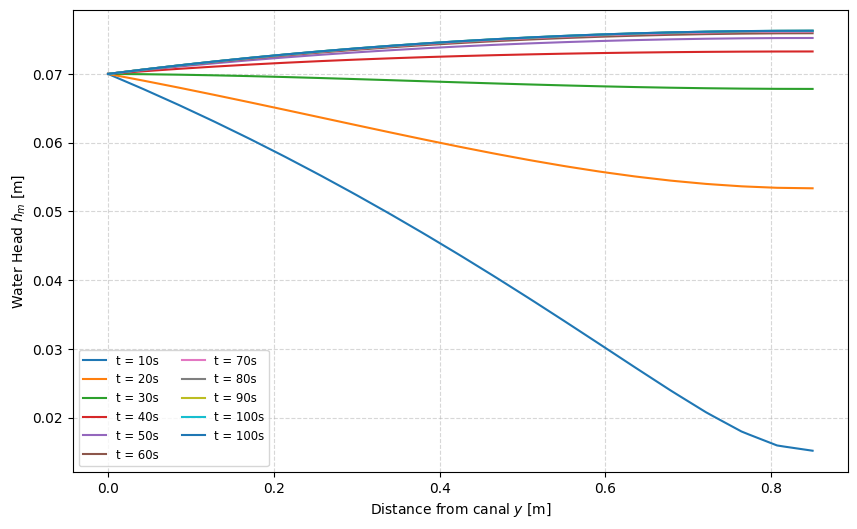

In [ ]:
Ly = 0.85
plt.figure(figsize=(10, 6))

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profs):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_times[i]:.0f}s')

#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='lower left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_constanthcm.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

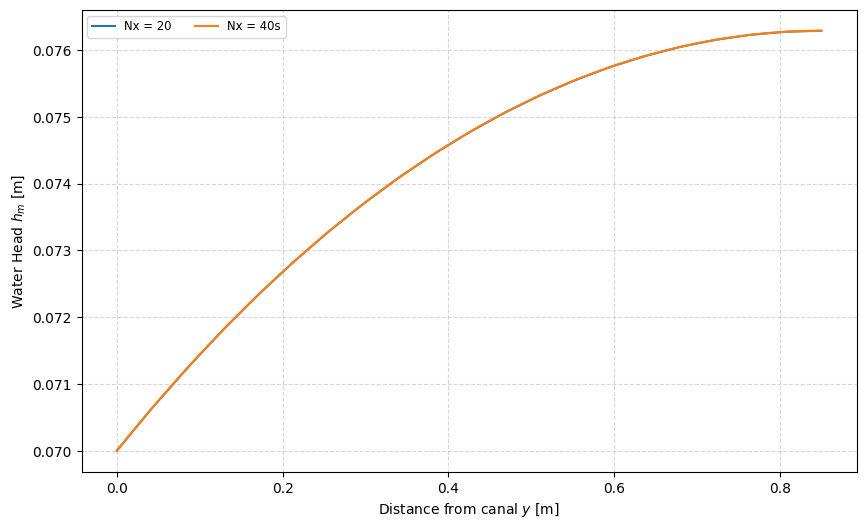

In [ ]:
plt.figure(figsize=(10, 6))
Ly = 0.85

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profs[-1], label=f'Nx = 20')
plt.plot(y_plot, hm_profs2[-1], label=f'Nx = 40s')

#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_constanthcm_convergence.png",dpi=1000,format="png",bbox_inches="tight")

plt.show()

In [ ]:
t2s3, hcm2s3, rain2s3, hm_profs3, prof_times3 = Darcy_model(t_end=200,nx=20,thet=0,cas=0,CFL=2.3)

Time is:  2.6671087499999846
Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.0

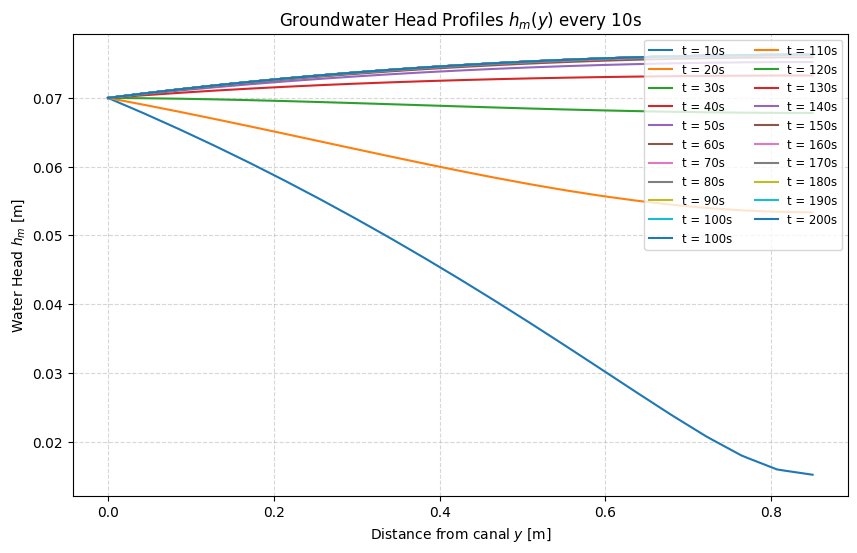

In [ ]:
plt.figure(figsize=(10, 6))
Ly = 0.85

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profs3):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_times3[i]:.0f}s')

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='lower left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

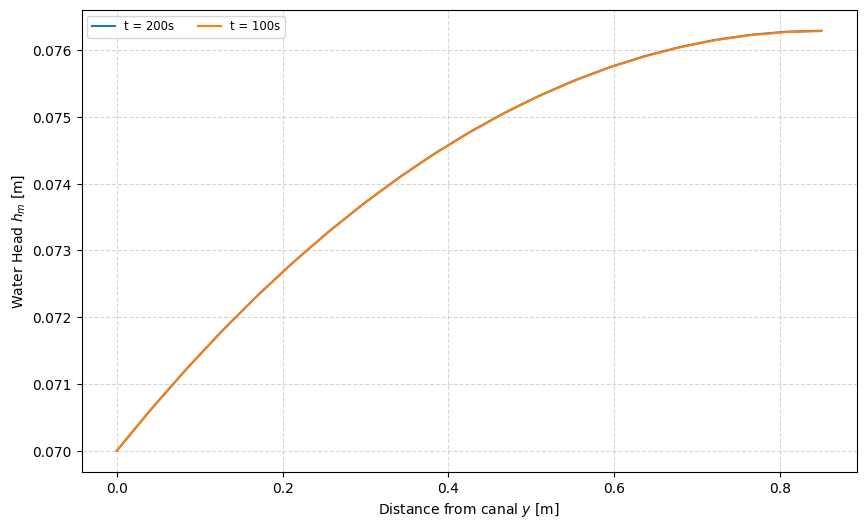

In [ ]:
plt.figure(figsize=(10, 6))
Ly = 0.85

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profs3[-1],label=f't = {prof_times3[-1]:.0f}s')
plt.plot(y_plot, hm_profs3[-11],label=f't = {prof_times3[-11]:.0f}s')

#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_constanthcm_ss.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

**Use non constant hcm, i.e nncase==1**

In [20]:
t2s4, hcm2s4, rain2s4, hm_profs4, prof_times4 = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.00137468758498
Time is:  98.66

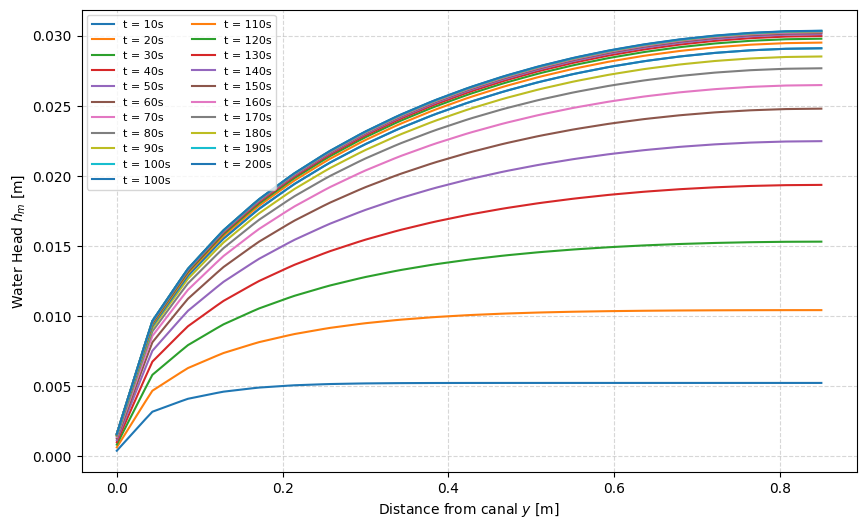

In [ ]:
plt.figure(figsize=(10, 6))
Ly = 0.85

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profs4):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_times4[i]:.0f}s')

#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='8')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_overflow.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

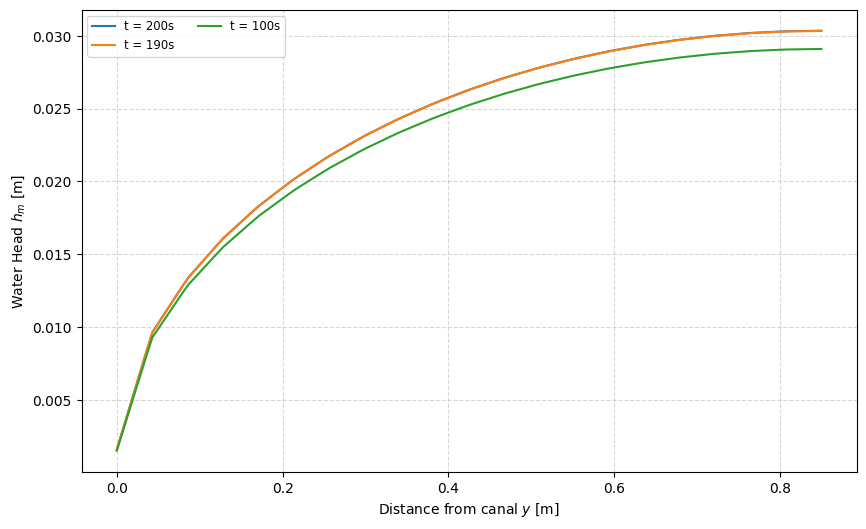

In [ ]:
plt.figure(figsize=(10, 6))
Ly = 0.85

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profs4[-1],label=f't = {prof_times4[-1]:.0f}s')
plt.plot(y_plot, hm_profs4[-2],label=f't = {prof_times4[-2]:.0f}s')

plt.plot(y_plot, hm_profs4[-11],label=f't = {prof_times4[-11]:.0f}s')

#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_overflow_ss.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

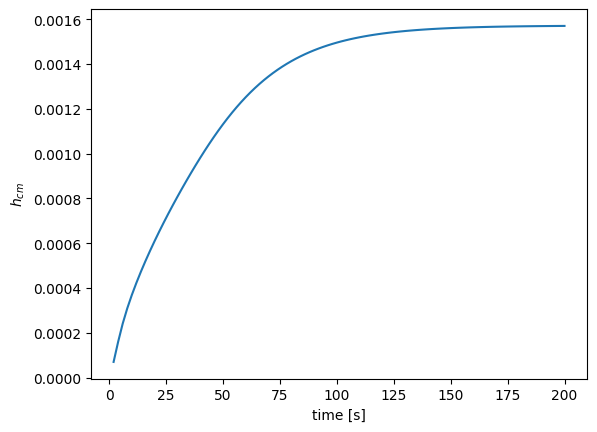

In [ ]:
plt.plot(t2s4, hcm2s4)
plt.xlabel("time [s]")
plt.ylabel("$h_{cm}$")
plt.savefig("hcm_ss.png",dpi=1000,format="png",bbox_inches="tight")

In [ ]:
t2s5, hcm2s5, rain2s5, hm_profs5, prof_times5 = Darcy_model(t_end=200,nx=40,thet=0,cas=1,CFL=2.3)

Time is:  2.6671087499999278
Time is:  5.333698203124172
Time is:  8.000287656248416
Time is:  10.66687710937266
Time is:  13.333466562496904
Time is:  16.000056015621148
Time is:  18.667164765629515
Time is:  21.33375421876288
Time is:  24.000343671896246
Time is:  26.66693312502961
Time is:  29.333522578162977
Time is:  32.00011203129634
Time is:  34.66670148441146
Time is:  37.33381023440158
Time is:  40.000399687516705
Time is:  42.66698914063183
Time is:  45.33357859374695
Time is:  48.00016804686207
Time is:  50.666757499977194
Time is:  53.33334695309232
Time is:  56.00045570308244
Time is:  58.66704515619756
Time is:  61.33363460931268
Time is:  64.0002240624278
Time is:  66.66681351554293
Time is:  69.33340296865805
Time is:  72.00051171864817
Time is:  74.66710117176329
Time is:  77.33369062487841
Time is:  80.00028007799354
Time is:  82.66686953110866
Time is:  85.33345898422378
Time is:  88.0000484373389
Time is:  90.66715718732902
Time is:  93.33374664044415
Time is:  96.0

In [ ]:
t2s6, hcm2s6, rain2s6, hm_profs6, prof_times6 = Darcy_model(t_end=200,nx=60,thet=0,cas=1,CFL=2.3)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6668779513894525
Time is:  5.333525104165619
Time is:  8.000172256939221
Time is:  10.666819409723084
Time is:  13.333466562506947
Time is:  16.00011371529081
Time is:  18.666760868054148
Time is:  21.333408020817487
Time is:  24.000055173580826
Time is:  26.666702326344165
Time is:  29.333349479107504
Time is:  32.00022743048196
Time is:  34.666874583286344
Time is:  37.33352173609073
Time is:  40.00016888889512
Time is:  42.666816041699505
Time is:  45.33346319450389
Time is:  48.00011034730828
Time is:  50.666757500112666
Time is:  53.333404652917054
Time is:  56.00005180572144
Time is:  58.66669895852583
Time is:  61.333346111330215
Time is:  64.00022406274572
Time is:  66.6668712155501
Time is:  69.33351836835449
Time is:  72.00016552115888
Time is:  74.66681267396326
Time is:  77.33345982676765
Time is:  80.00010697957204
Time is:  82.66675413237643
Time is:  85.33340128518081
Time is:  88.0000484379852
Time is:  90.66669559078959
Time is:  93.33334274359397
Time is: 

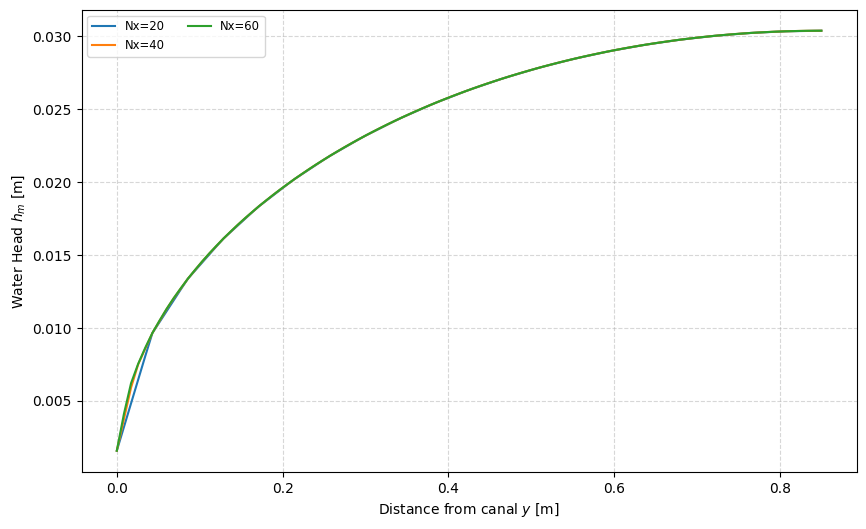

In [ ]:
plt.figure(figsize=(10, 6))
Ly = 0.85

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profs4[-1],label=f'Nx=20')
plt.plot(y_plot, hm_profs5[-1],label=f'Nx=40')
plt.plot(y_plot, hm_profs6[-1],label=f'Nx=60')


#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_overflow_convergence.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def run_groundwater_fd(t_end=200, nx=20):
    # --- Physical Parameters (from your Firedrake code) ---
    Ly    = 0.85
    mpor  = 0.3
    sigma = 0.8
    Lc    = 0.05
    kperm = 1e-8
    nu    = 1.0e-6
    g     = 9.81
    R     = 0.000125

    alpha = kperm / (nu * mpor * sigma)
    gam   = Lc / (mpor * sigma)
    fac2  = np.sqrt(g) / (mpor * sigma)

    # --- Grid and Time Stepping ---
    dy = Ly / nx
    y  = np.linspace(0, Ly, nx + 1)

    # CFL-based time step (matching your Firedrake Dt)
    CFL = 1
    dt  = CFL * 0.5 * dy**2
    nt  = int(t_end / dt)

    # Initial Condition: h = 0 everywhere
    h = np.zeros(nx + 1)

    # Data storage
    time_series = []
    hcm_series = []

    # --- Time Stepping Loop ---
    t = 0.0
    for n in range(nt):
        h_new = np.copy(h)

        # 1. Interior Points (i = 1 to nx-1)
        # Using the identity: d/dy(h dh/dy) = 0.5 * d^2/dy^2(h^2)
        for i in range(1, nx):
            term_diff = (h[i+1]**2 - 2*h[i]**2 + h[i-1]**2) / (2 * dy**2)
            source    = R / (mpor * sigma)
            h_new[i]  = h[i] + dt * (alpha * g * term_diff + source)

        # 2. Boundary Condition at y = Ly (i = nx): No-flow (dh/dy = 0)
        # Using a ghost-point approach: h[nx+1] = h[nx-1]
        term_diff_end = (2*h[nx-1]**2 - 2*h[nx]**2) / (2 * dy**2)
        h_new[nx] = h[nx] + dt * (alpha * g * term_diff_end + R / (mpor * sigma))

        # 3. Boundary Condition at y = 0 (i = 0): Canal/Weir Equation (14)
        # Lc * dh/dt = (mpor*sigma/2)*alpha*g*d(h^2)/dy - weir_term
        # We use a forward difference for the spatial derivative at the tiny source area
        dh2_dy = (h[1]**2 - h[0]**2) / dy
        weir_term = np.sqrt(g) * np.power(max(2.0/3.0 * h[0], 0.0), 1.5)

        # Update h[0] (h_cm)
        h_new[0] = h[0] + (dt / Lc) * ( (mpor*sigma/2.0) * alpha * g * dh2_dy - weir_term )

        # Update time and solution
        h = np.copy(h_new)
        t += dt

        # Data collection (every 2s approx)
        if round(t, 4) % 2.0 < dt:
            time_series.append(t)
            hcm_series.append(h[0])

    return time_series, hcm_series, y, h

**Self-Adjoint**

In [120]:
import numpy as np

def run_groundwater_fd_self(t_end=200, nx=20):
    # --- Physical Parameters ---
    Ly    = 0.85
    mpor  = 0.3
    sigma = 0.8
    Lc    = 0.05
    kperm = 1e-8
    nu    = 1.0e-6
    g     = 9.81
    R     = 0.000125

    alpha = kperm / (nu * mpor * sigma)

    dy = Ly / nx
    y  = np.linspace(0, Ly, nx + 1)

    CFL = 1.0 # Stability is safer with 1.0 for nonlinear problems
    dt  = CFL * 0.5 * dy**2
    nt  = int(t_end / dt)

    h = np.zeros(nx + 1)
    time_series, hcm_series = [], []

    t = 0.0
    for n in range(nt):
        h_new = np.copy(h)
        source = R / (mpor * sigma)

        for i in range(1, nx):
            p_plus  = alpha * g * (h[i+1] + h[i]) / 2.0
            p_minus = alpha * g * (h[i] + h[i-1]) / 2.0

            flux_term = (p_plus * (h[i+1] - h[i]) - p_minus * (h[i] - h[i-1])) / (dy**2)
            h_new[i] = h[i] + dt * (flux_term + source)

        p_minus_end = alpha * g * (h[nx] + h[nx-1]) / 2.0
        flux_end = (0.0 - p_minus_end * (h[nx] - h[nx-1])) / (dy**2)
        h_new[nx] = h[nx] + dt * (flux_end + source)


        p_interface = alpha * g * (h[1] + h[0]) / 2.0
        grad_h_interface = (h[1] - h[0]) / dy

        groundwater_flux = (mpor * sigma) * p_interface * grad_h_interface
        weir_term = np.sqrt(g) * np.power(max(2.0/3.0 * h[0], 0.0), 1.5)

        h_new[0] = h[0] + (dt / Lc) * (groundwater_flux - weir_term)

        h = np.copy(h_new)
        t += dt

        if round(t, 4) % 2.0 < dt:
            time_series.append(t)
            hcm_series.append(h[0])

    return time_series, hcm_series, y, h

In [22]:
t2scomp, hcm2scomp, rain2scomp, hm_profscomp, prof_timescomp = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.00137468758498
Time is:  98.66848343759335
Time is:  101.33351500010171
Time is:  104.00062375011008
Time is:  106.66773250011845
Time is:  109.33484125012681
Time is:  112.00195000013518
Time is:  114.66698156264354
Time is:  117.33409031265191
Time is:  120.00119906266028
Time is:  1

In [121]:
times, hcm, y_grid, h_final = run_groundwater_fd()
times_self,hcmself,y_grid_self,h_final_self = run_groundwater_fd_self()


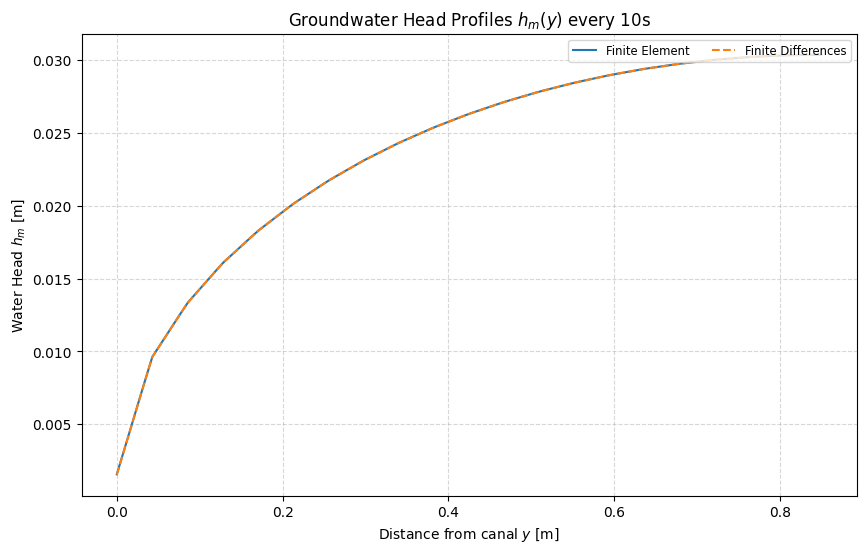

In [122]:
plt.figure(figsize=(10, 6))
Ly=0.85
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

plt.plot(y_plot, hm_profscomp[-1], label="Finite Element")
plt.plot(y_grid, h_final,linestyle='--',label="Finite Differences")

#

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
#plt.savefig("waterhead_comparison.png",dpi=500,format="png",bbox_inches="tight")
plt.show()

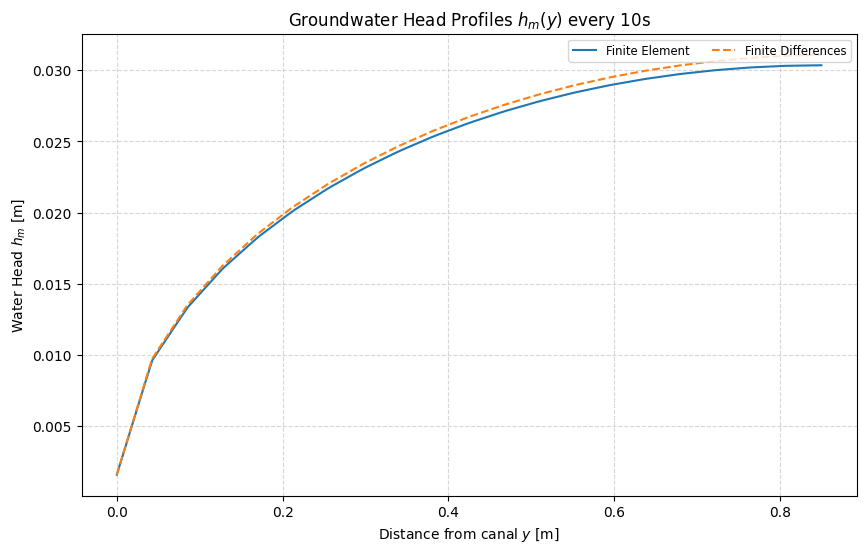

In [128]:
plt.figure(figsize=(10, 6))
Ly=0.85
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

plt.plot(y_plot, hm_profscomp[-1], label="Finite Element")
plt.plot(y_grid, h_final_self,linestyle='--',label="Finite Differences")

#

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("selfwaterhead_comparison.png",dpi=500,format="png",bbox_inches="tight")
plt.show()

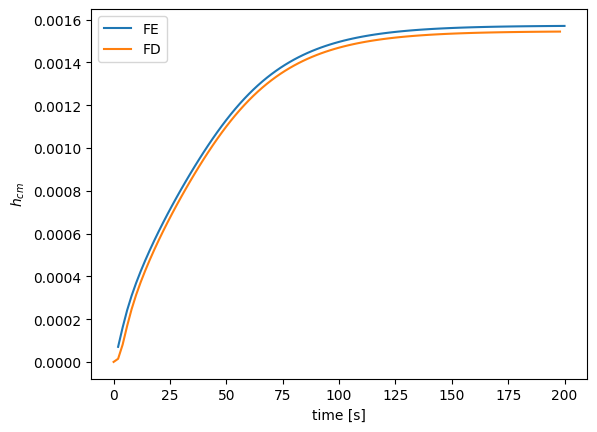

In [125]:
plt.plot(t2scomp, hcm2scomp,label="FE")
plt.plot(times, hcm,label="FD")
plt.xlabel("time [s]")
plt.ylabel("$h_{cm}$")
plt.legend()
#plt.savefig("hcm_comparison.png",dpi=700,format="png",bbox_inches="tight")

#plt.savefig("hcm_ss.png",dpi=1000,format="png",bbox_inches="tight")

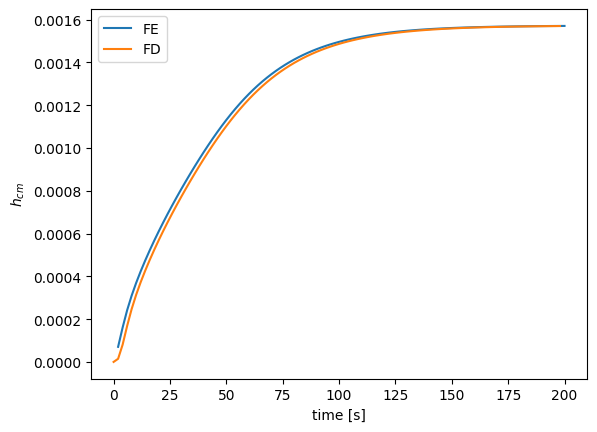

In [127]:
plt.plot(t2scomp, hcm2scomp,label="FE")
plt.plot(times, hcmself,label="FD")
plt.xlabel("time [s]")
plt.ylabel("$h_{cm}$")
plt.legend()
plt.savefig("selfhcm_comparison.png",dpi=700,format="png",bbox_inches="tight")

#plt.savefig("hcm_ss.png",dpi=1000,format="png",bbox_inches="tight")

In [78]:
times20, hcm20, y_grid20, h_final20 = run_groundwater_fd(200,20)
times40, hcm40, y_grid40, h_final40 = run_groundwater_fd(200,40)
times80, hcm80, y_grid80, h_final80 = run_groundwater_fd(200,80)


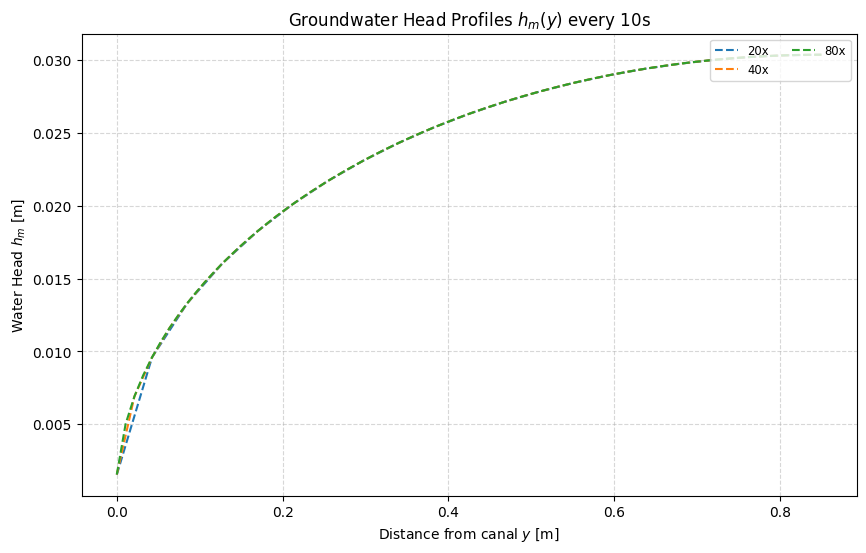

In [79]:
plt.figure(figsize=(10, 6))
Ly=0.85
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

plt.plot(y_grid20, h_final20,linestyle='--',label="20x")
plt.plot(y_grid40, h_final40,linestyle='--',label="40x")
plt.plot(y_grid80, h_final80,linestyle='--',label="80x")

#

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
#plt.savefig("waterhead_comparison.png",dpi=500,format="png",bbox_inches="tight")
plt.show()

Text(0, 0.5, '$h_{cm}$')

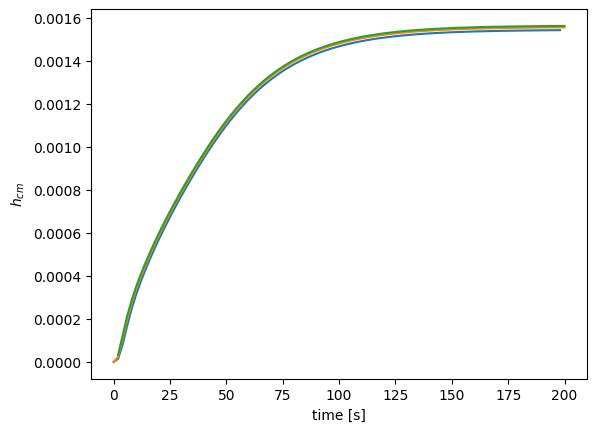

In [80]:
plt.plot(times20, hcm20)
plt.plot(times40, hcm40)
plt.plot(times80, hcm80)
plt.xlabel("time [s]")
plt.ylabel("$h_{cm}$")
#plt.savefig("hcm_comparison.png",dpi=500,format="png",bbox_inches="tight")

**Variable Rainfall**

In [35]:
from firedrake import *
#
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt # OB2025

def flux ( h , phi , R,alpha,g,mpor,sigma ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

def Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=0):
  m  = nx
  Ly = 0.85
  dy = Ly/m
  mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
  y, = SpatialCoordinate(mesh) # OB2025

# Time definitions
  t   = 0.0
  end = t_end
  Ntm = 75
  dtmeas = end/Ntm
  tmeas = dtmeas

#
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
  nCG = 1 # OB2025
  V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
  CFL = 2.3
  Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

  dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
  theta = thet

# Define Groundwater constants
  mpor  = 0.3
  sigma = 0.8
  Lc    = 0.05
  kperm = 1e-8
  w     = 0.1
  R     = Constant(0.000125)
  nu    = 1.0e-6
  g     = 9.81
  alpha = kperm/( nu * mpor * sigma )
  gam   = Lc/( mpor*sigma )
  fac2  = sqrt(g)/( mpor*sigma )
#
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
  nncase = cas

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
  h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
  outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
  outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

  phi = TestFunction(V)

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

  if nncase == 0:
    h = Function(V)
    h.assign(h_prev)
    F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ,alpha,g,mpor,sigma) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
    bc1 = DirichletBC(V, 0.07, 1)
    h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)
  elif nncase == 1:
    if theta == 0.0:
      h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
      explicit_problem = LinearVariationalProblem(aa, L, out)
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij',
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
    elif theta > 0.0:
      h = Function(V)
      h.assign(h_prev)
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
     # Add boundary contributions at y = 0:
      F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
      h_problem = NonlinearVariationalProblem( F+F2 , h )
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})

  time_2s, hcm_2s, rain_2s = [], [], []
  hm_profs_10s, prof_times = [], []
  rain_duration=rain
  Rmax=0.000125
  while (t < end):
    t += Dt
    # Print to console the current time
    if (t % 10.0) < rain_duration:
        R_current = Rmax
    else:
        R_current = 0.0
    R.assign(R_current)
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if round(t, 4) % 2.0 < Dt:
        time_2s.append(t)
        hcm_2s.append(h_prev.at(0.0))
        rain_2s.append(float(R))
    if round(t, 4) % 10.0 < Dt:
        #print(f'Capturing profile at Time: {t:.2f}')
        y_pts = np.linspace(0, Ly, 100)
        hm_profs_10s.append([h_prev.at(yi) for yi in y_pts])
        prof_times.append(t)

    if t>tmeas:
        print('Time is: ',t)
        tmeas = tmeas+dtmeas
        outfile.write(h_prev , t = t )
  return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times

In [36]:
t2svar, hcm2svar, rain2svar, hm_profsvar, prof_timesvar = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=1)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.00137468758498
Time is:  98.66848343759335
Time is:  101.33351500010171
Time is:  104.00062375011008
Time is:  106.66773250011845
Time is:  109.33484125012681
Time is:  112.00195000013518
Time is:  114.66698156264354
Time is:  117.33409031265191
Time is:  120.00119906266028
Time is:  122.66830781266864
Time is:  125.333339375177
Time is:  128.00044812518536
Time is:  130.66755687517548
Time is:  133.3346656251656
Time is:  

In [37]:
t2svar2, hcm2svar2, rain2svar2, hm_profsvar2, prof_timesvar2 = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=2)

Time is:  2.6671087499999846
Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.0

In [38]:
t2svar4, hcm2svar4, rain2svar4, hm_profsvar4, prof_timesvar4 = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=4)

Time is:  2.6671087499999846
Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.0

In [39]:
t2svar9, hcm2svar9, rain2svar9, hm_profsvar9, prof_timesvar9 = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=9)

Time is:  2.6671087499999846
Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.0

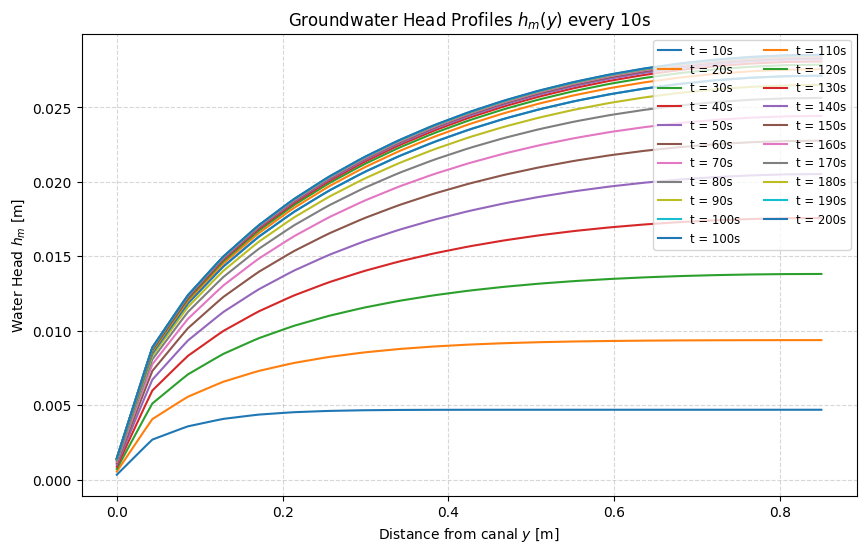

In [ ]:
plt.figure(figsize=(10, 6))
Ly=0.85
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profsvar9):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_timesvar[i]:.0f}s')

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

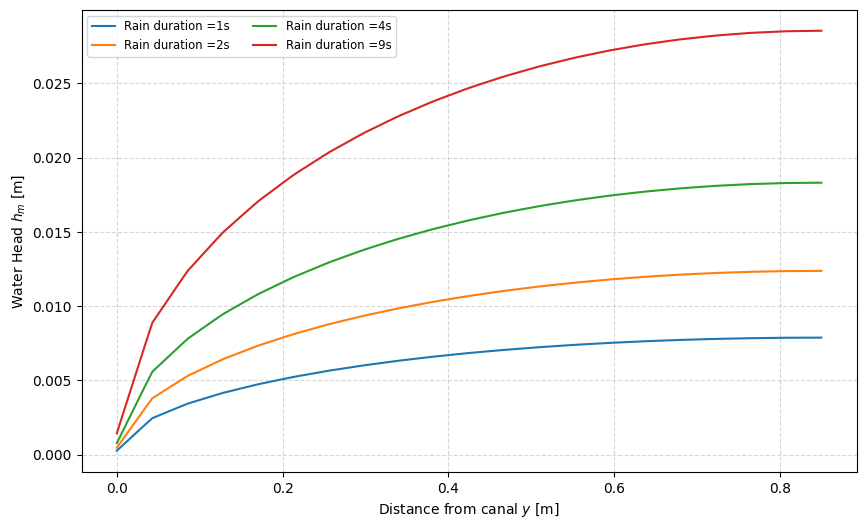

In [ ]:
plt.figure(figsize=(10, 6))

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profsvar[-1],label=f'Rain duration =1s')
plt.plot(y_plot, hm_profsvar2[-1],label=f'Rain duration =2s')
plt.plot(y_plot, hm_profsvar4[-1],label=f'Rain duration =4s')
plt.plot(y_plot, hm_profsvar9[-1],label=f'Rain duration =9s')


#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("water_head_overflow_var.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

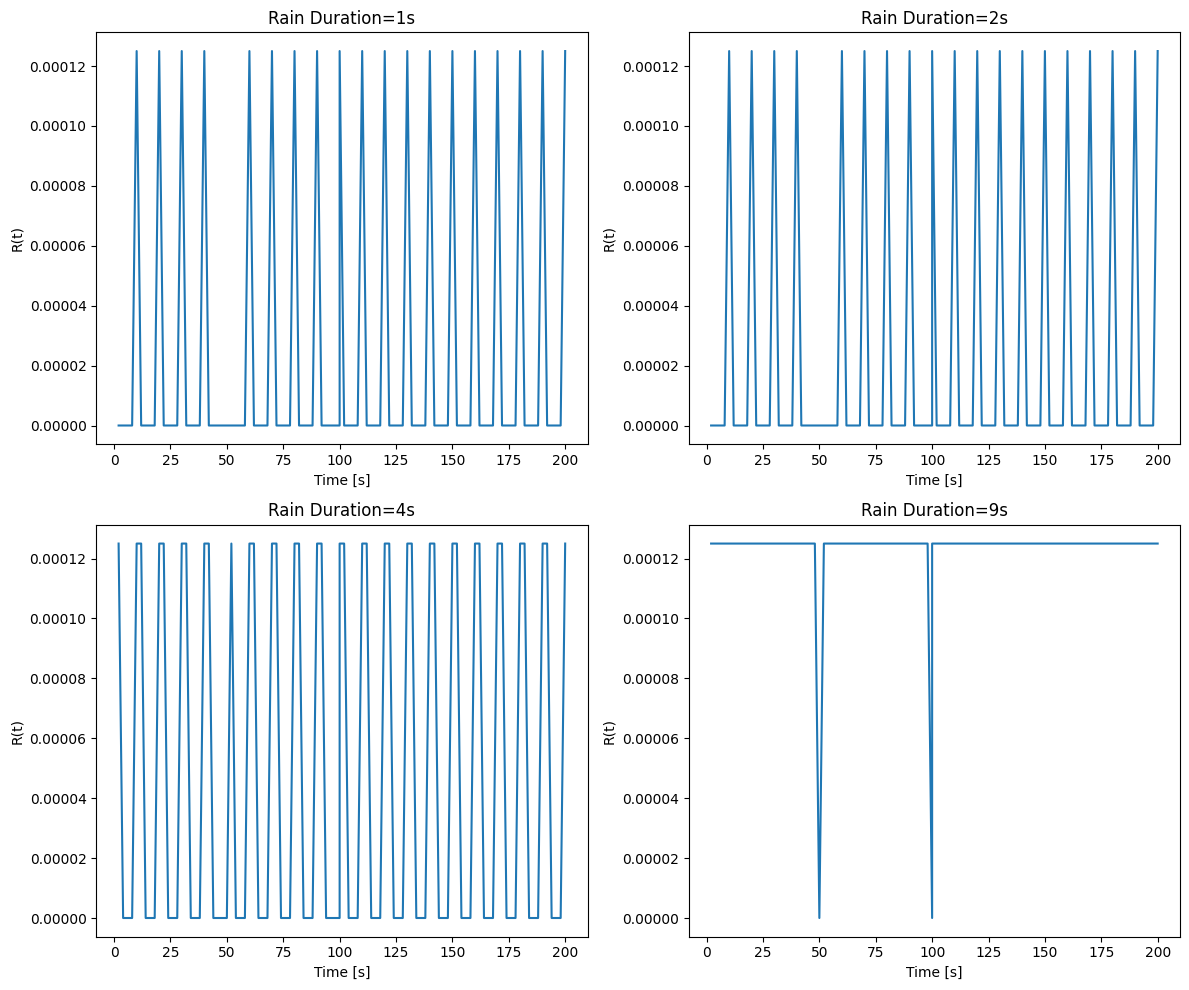

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(t2svar9, rain2svar)
axs[0, 0].set_title('Rain Duration=1s')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].set_ylabel('R(t)')

axs[0, 1].plot(t2svar9, rain2svar2)
axs[0, 1].set_title('Rain Duration=2s')
axs[0,1].set_xlabel('Time [s]')
axs[0,1].set_ylabel('R(t)')

axs[1, 0].plot(t2svar9, rain2svar4)
axs[1, 0].set_title('Rain Duration=4s')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylabel('R(t)')

axs[1, 1].plot(t2svar9, rain2svar9)
axs[1, 1].set_title('Rain Duration=9s')
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylabel('R(t)')

plt.tight_layout()
#plt.savefig("water_head_R.png",dpi=1000,format="png",bbox_inches="tight")

plt.show()


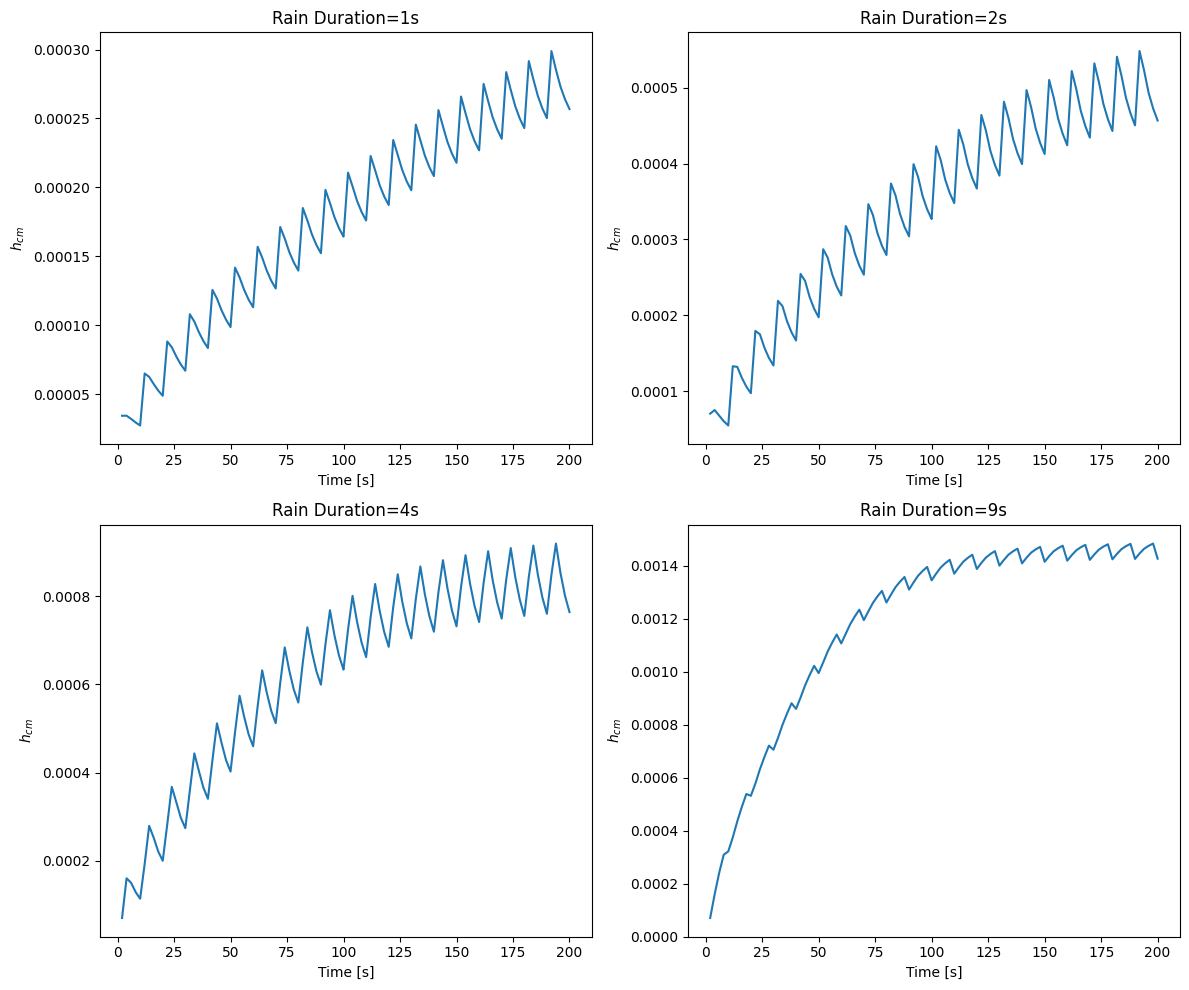

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(t2svar9, hcm2svar)
axs[0, 0].set_title('Rain Duration=1s')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].set_ylabel('$h_{cm}$')

axs[0, 1].plot(t2svar9, hcm2svar2)
axs[0, 1].set_title('Rain Duration=2s')
axs[0,1].set_xlabel('Time [s]')
axs[0,1].set_ylabel('$h_{cm}$')

axs[1, 0].plot(t2svar9, hcm2svar4)
axs[1, 0].set_title('Rain Duration=4s')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylabel('$h_{cm}$')

axs[1, 1].plot(t2svar9, hcm2svar9)
axs[1, 1].set_title('Rain Duration=9s')
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylabel('$h_{cm}$')

plt.tight_layout()
#plt.savefig("water_head_hcm_var.png",dpi=1000,format="png",bbox_inches="tight")

plt.show()

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def run_groundwater_fd_periodic(t_end=200, nx=20, rain_duration=4.0):
    # --- Physical Parameters ---
    Ly    = 0.85
    mpor  = 0.3
    sigma = 0.8
    Lc    = 0.05
    kperm = 1e-8
    nu    = 1.0e-6
    g     = 9.81
    Rmax  = 0.000125

    alpha = kperm / (nu * mpor * sigma)

    # --- Grid and Time Stepping ---
    dy = Ly / nx
    y  = np.linspace(0, Ly, nx + 1)

    CFL = 1
    dt  = CFL * 0.5 * dy**2
    nt  = int(t_end / dt)

    h = np.zeros(nx + 1)

    # Storage lists
    time_2s, hcm_2s, rain_2s = [], [], []
    hm_profs_10s, prof_times = [], []

    t = 0.0
    for n in range(nt):
        # 1. Determine Periodic Rainfall (Logic from your snippet)
        if (t % 10.0) < rain_duration:
            R_current = Rmax
        else:
            R_current = 0.0

        # 2. Finite Difference Update
        h_new = np.copy(h)
        source = R_current / (mpor * sigma)

        # Interior Points
        for i in range(1, nx):
            term_diff = (h[i+1]**2 - 2*h[i]**2 + h[i-1]**2) / (2 * dy**2)
            h_new[i]  = h[i] + dt * (alpha * g * term_diff + source)

        # Boundary y = Ly (No-flow)
        term_diff_end = (2*h[nx-1]**2 - 2*h[nx]**2) / (2 * dy**2)
        h_new[nx] = h[nx] + dt * (alpha * g * term_diff_end + source)

        # Boundary y = 0 (Weir/Canal)
        # Note the 'tiny curved area' is handled by Lc scaling
        dh2_dy = (h[1]**2 - h[0]**2) / dy
        weir_term = np.sqrt(g) * np.power(max(2.0/3.0 * h[0], 0.0), 1.5)
        h_new[0] = h[0] + (dt / Lc) * ( (mpor*sigma/2.0) * alpha * g * dh2_dy - weir_term )

        # 3. Data Collection (Matching your logic)
        if round(t, 4) % 2.0 < dt:
            time_2s.append(t)
            hcm_2s.append(h_new[0])
            rain_2s.append(R_current)

        if round(t, 4) % 10.0 < dt:
            hm_profs_10s.append(np.copy(h_new))
            prof_times.append(t)

        h = np.copy(h_new)
        t += dt

    return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times, y

# Run the simulation
time_fd1s, hcm_fd1s, rain_fd1s, hm_profs_fd1s, prof_timesfd1s, y_grid = run_groundwater_fd_periodic(t_end=200, nx=20, rain_duration=1.0)
time_fd2s, hcm_fd2s, rain_fd2s, hm_profs_fd2s, prof_timesfd2s, y_grid = run_groundwater_fd_periodic(t_end=200, nx=20, rain_duration=2.0)
time_fd4s, hcm_fd4s, rain_fd4s, hm_profs_fd4s, prof_timesfd4s, y_grid = run_groundwater_fd_periodic(t_end=200, nx=20, rain_duration=4.0)
time_fd9s, hcm_fd9s, rain_fd9s, hm_profs_fd9s, prof_timesfd9s, y_grid = run_groundwater_fd_periodic(t_end=200, nx=20, rain_duration=9.0)



 **Self Adjoint**

In [116]:
import numpy as np

def run_groundwater_fd_periodic_self(t_end=200, nx=20, rain_duration=4.0):
    # --- Physical Parameters ---
    Ly    = 0.85
    mpor  = 0.3
    sigma = 0.8
    Lc    = 0.05
    kperm = 1e-8
    nu    = 1.0e-6
    g     = 9.81
    Rmax  = 0.000125

    alpha = kperm / (nu * mpor * sigma)

    # --- Grid and Time Stepping ---
    dy = Ly / nx
    y  = np.linspace(0, Ly, nx + 1)

    # Stability: Self-adjoint nonlinear forms often prefer CFL <= 1.0
    CFL = 1
    dt  = CFL * 0.5 * dy**2
    nt  = int(t_end / dt)

    h = np.zeros(nx + 1)

    # Storage lists
    time_2s, hcm_2s, rain_2s = [], [], []
    hm_profs_10s, prof_times = [], []

    t = 0.0
    for n in range(nt):
        # 1. Periodic Rainfall Logic
        if (t % 10.0) < rain_duration:
            R_current = Rmax
        else:
            R_current = 0.0

        h_new = np.copy(h)
        source = R_current / (mpor * sigma)


        for i in range(1, nx):
            p_plus  = alpha * g * (h[i+1] + h[i]) / 2.0
            p_minus = alpha * g * (h[i] + h[i-1]) / 2.0

            flux_diff = (p_plus * (h[i+1] - h[i]) - p_minus * (h[i] - h[i-1])) / (dy**2)
            h_new[i] = h[i] + dt * (flux_diff + source)

        p_minus_end = alpha * g * (h[nx] + h[nx-1]) / 2.0
        flux_end = (0.0 - p_minus_end * (h[nx] - h[nx-1])) / (dy**2)
        h_new[nx] = h[nx] + dt * (flux_end + source)


        p_interface = alpha * g * (h[1] + h[0]) / 2.0

        groundwater_flux = (mpor * sigma) * p_interface * (h[1] - h[0]) / dy
        weir_term = np.sqrt(g) * np.power(max(2.0/3.0 * h[0], 0.0), 1.5)

        h_new[0] = h[0] + (dt / Lc) * (groundwater_flux - weir_term)

        # Data Collection
        if round(t, 4) % 2.0 < dt:
            time_2s.append(t)
            hcm_2s.append(h_new[0])
            rain_2s.append(R_current)

        if round(t, 4) % 10.0 < dt:
            hm_profs_10s.append(np.copy(h_new))
            prof_times.append(t)

        h = np.copy(h_new)
        t += dt

    return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times, y

time_fd1self, hcm_fd1self, rain_fd1self, hm_profs_fd1self, prof_timesfd1self, y_grid = run_groundwater_fd_periodic_self(t_end=200, nx=20, rain_duration=1.0)
time_fd2self, hcm_fd2self, rain_fd2self, hm_profs_fd2self, prof_timesfd2self, y_grid = run_groundwater_fd_periodic_self(t_end=200, nx=20, rain_duration=2.0)
time_fd4self, hcm_fd4self, rain_fd4self, hm_profs_fd4self, prof_timesfd4self, y_grid = run_groundwater_fd_periodic_self(t_end=200, nx=20, rain_duration=4.0)
time_fd9self, hcm_fd9self, rain_fd9self, hm_profs_fd9self, prof_timesfd9self, y_grid = run_groundwater_fd_periodic_self(t_end=200, nx=20, rain_duration=9.0)

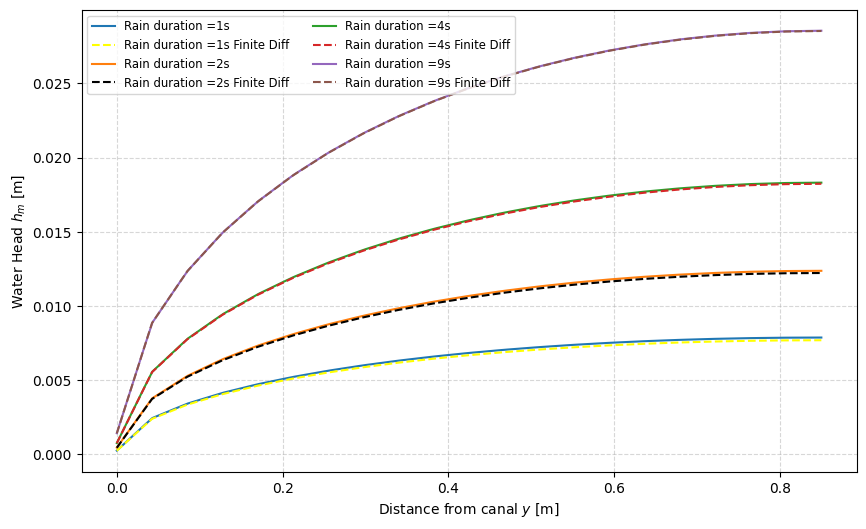

In [114]:
plt.figure(figsize=(10, 6))

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profsvar[-1],label=f'Rain duration =1s')
plt.plot(y_grid,hm_profs_fd1s[-1],linestyle="--",label=f'Rain duration =1s Finite Diff',color="yellow")
plt.plot(y_plot, hm_profsvar2[-1],label=f'Rain duration =2s')
plt.plot(y_grid,hm_profs_fd2s[-1],linestyle="--",label=f'Rain duration =2s Finite Diff',color="black")

plt.plot(y_plot, hm_profsvar4[-1],label=f'Rain duration =4s')
plt.plot(y_grid,hm_profs_fd4s[-1],linestyle="--",label=f'Rain duration =4s Finite Diff')

plt.plot(y_plot, hm_profsvar9[-1],label=f'Rain duration =9s')
plt.plot(y_grid,hm_profs_fd9s[-1],linestyle="--",label=f'Rain duration =9s Finite Diff')



#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
#plt.savefig("var_rainfall_comp.png",dpi=500,format="png",bbox_inches="tight")
plt.show()

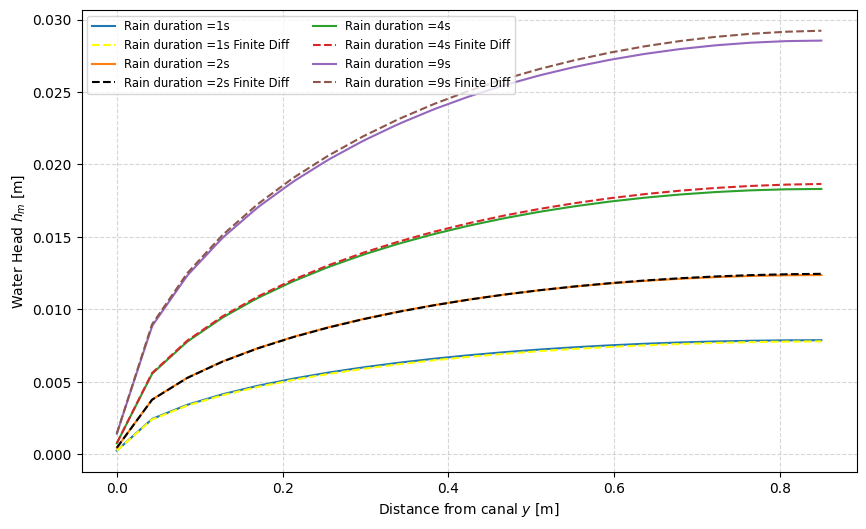

In [129]:
plt.figure(figsize=(10, 6))

# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one

plt.plot(y_plot, hm_profsvar[-1],label=f'Rain duration =1s')
plt.plot(y_grid,hm_profs_fd1self[-1],linestyle="--",label=f'Rain duration =1s Finite Diff',color="yellow")
plt.plot(y_plot, hm_profsvar2[-1],label=f'Rain duration =2s')
plt.plot(y_grid,hm_profs_fd2self[-1],linestyle="--",label=f'Rain duration =2s Finite Diff',color="black")

plt.plot(y_plot, hm_profsvar4[-1],label=f'Rain duration =4s')
plt.plot(y_grid,hm_profs_fd4self[-1],linestyle="--",label=f'Rain duration =4s Finite Diff')

plt.plot(y_plot, hm_profsvar9[-1],label=f'Rain duration =9s')
plt.plot(y_grid,hm_profs_fd9self[-1],linestyle="--",label=f'Rain duration =9s Finite Diff')



#plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("selfvar_rainfall_comp.png",dpi=500,format="png",bbox_inches="tight")
plt.show()

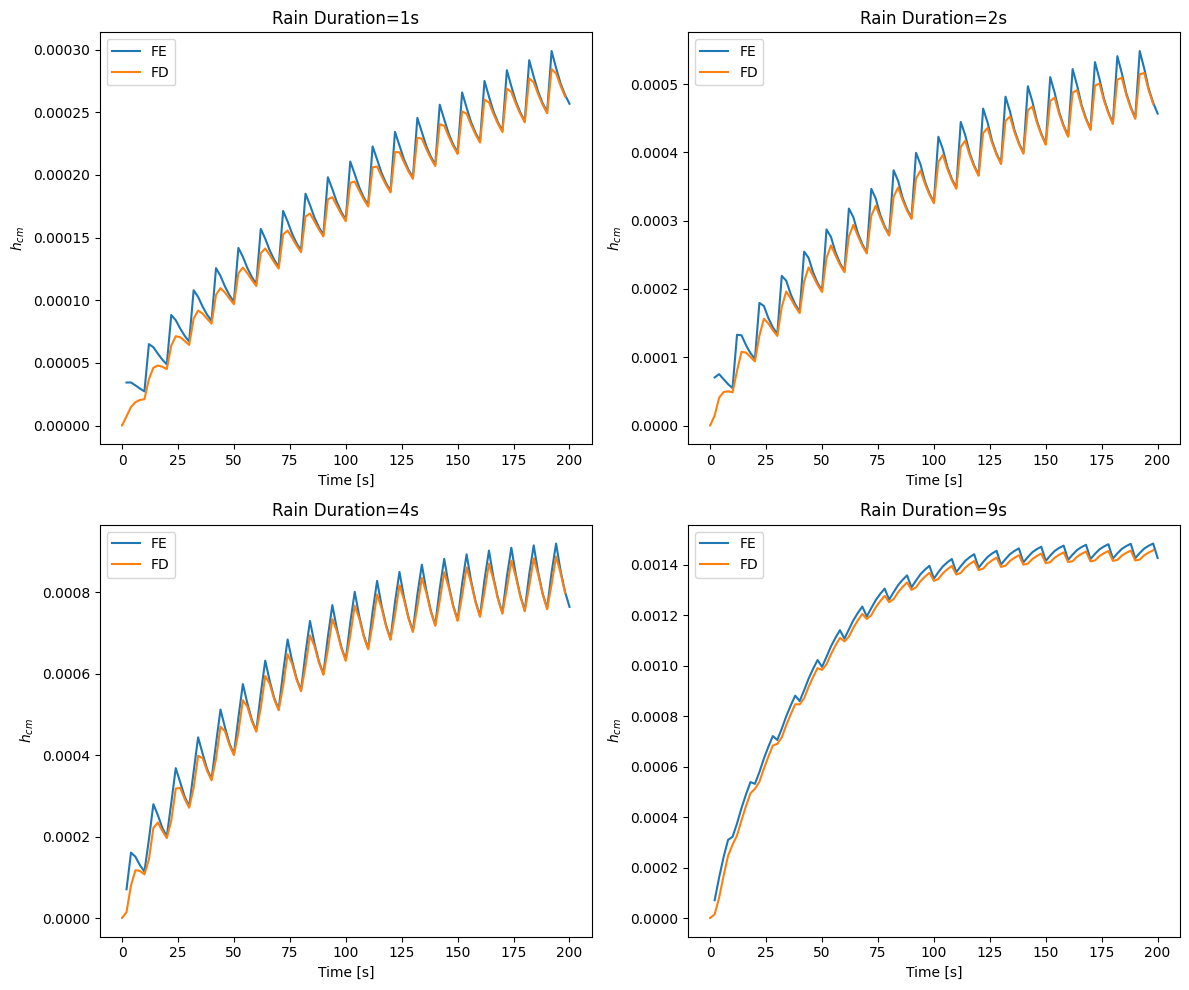

In [115]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(t2svar9, hcm2svar,label="FE")
axs[0,0].plot(time_fd1s, hcm_fd1s,label="FD")
axs[0, 0].set_title('Rain Duration=1s')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].set_ylabel('$h_{cm}$')
axs[0,0].legend()

axs[0, 1].plot(t2svar9, hcm2svar2,label="FE")
axs[0,1].plot(time_fd2s, hcm_fd2s,label="FD")
axs[0, 1].set_title('Rain Duration=2s')
axs[0,1].set_xlabel('Time [s]')
axs[0,1].set_ylabel('$h_{cm}$')
axs[0,1].legend()


axs[1, 0].plot(t2svar9, hcm2svar4,label="FE")
axs[1,0].plot(time_fd4s, hcm_fd4s,label="FD")

axs[1, 0].set_title('Rain Duration=4s')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylabel('$h_{cm}$')
axs[1,0].legend()


axs[1, 1].plot(t2svar9, hcm2svar9,label="FE")
axs[1,1].plot(time_fd9s, hcm_fd9s,label="FD")

axs[1, 1].set_title('Rain Duration=9s')
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylabel('$h_{cm}$')
axs[1,1].legend()



plt.tight_layout()
#plt.savefig("water_head_hcm_var.png",dpi=1000,format="png",bbox_inches="tight")
#plt.savefig("var_rainfallhcm_comp.png",dpi=500,format="png",bbox_inches="tight")

plt.show()

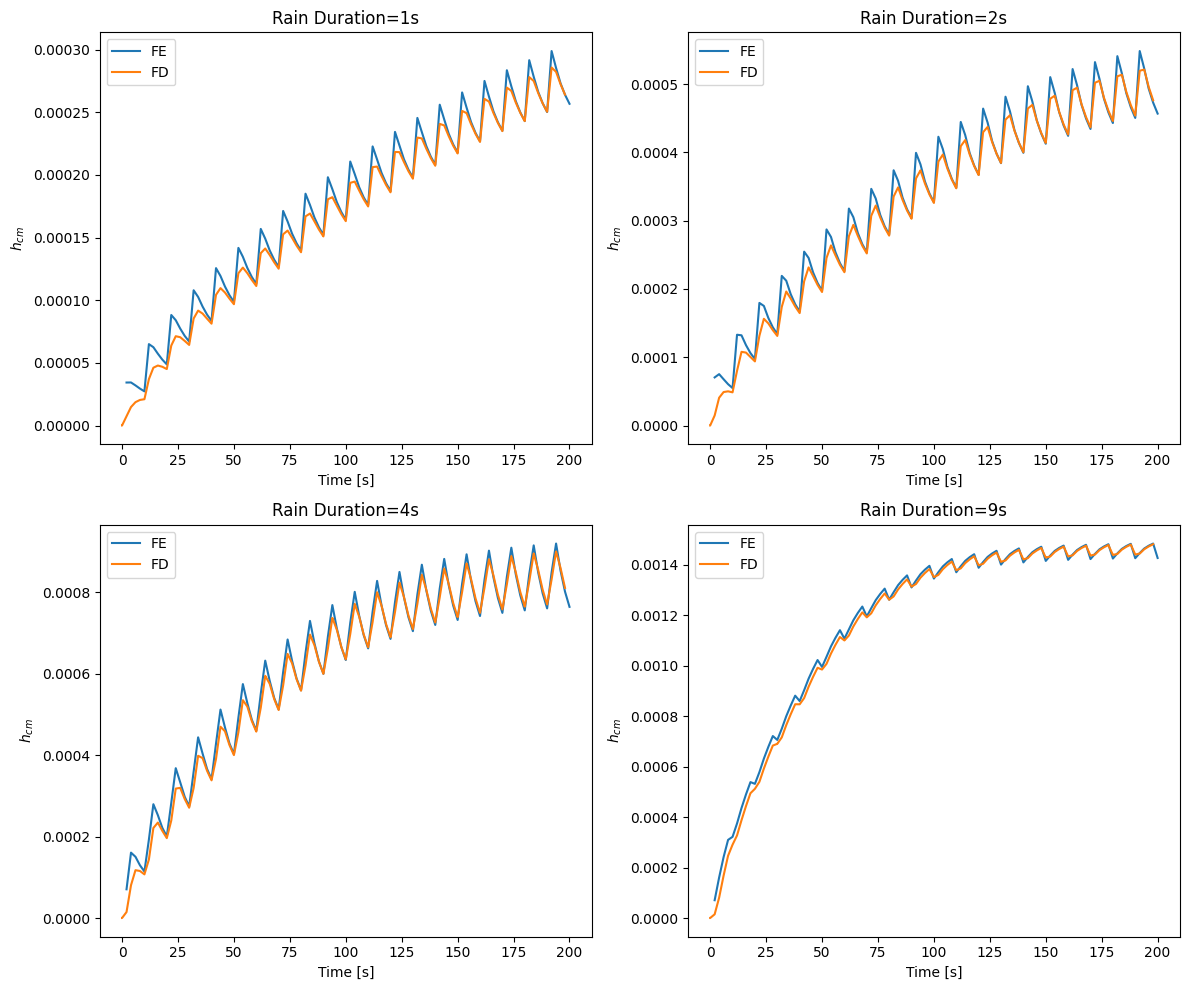

In [130]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(t2svar9, hcm2svar,label="FE")
axs[0,0].plot(time_fd1s, hcm_fd1self,label="FD")
axs[0, 0].set_title('Rain Duration=1s')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].set_ylabel('$h_{cm}$')
axs[0,0].legend()

axs[0, 1].plot(t2svar9, hcm2svar2,label="FE")
axs[0,1].plot(time_fd2s, hcm_fd2self,label="FD")
axs[0, 1].set_title('Rain Duration=2s')
axs[0,1].set_xlabel('Time [s]')
axs[0,1].set_ylabel('$h_{cm}$')
axs[0,1].legend()


axs[1, 0].plot(t2svar9, hcm2svar4,label="FE")
axs[1,0].plot(time_fd4s, hcm_fd4self,label="FD")

axs[1, 0].set_title('Rain Duration=4s')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylabel('$h_{cm}$')
axs[1,0].legend()


axs[1, 1].plot(t2svar9, hcm2svar9,label="FE")
axs[1,1].plot(time_fd9s, hcm_fd9self,label="FD")

axs[1, 1].set_title('Rain Duration=9s')
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylabel('$h_{cm}$')
axs[1,1].legend()



plt.tight_layout()
plt.savefig("self water_head_hcm_var.png",dpi=500,format="png",bbox_inches="tight")
#plt.savefig("var_rainfallhcm_comp.png",dpi=500,format="png",bbox_inches="tight")

plt.show()

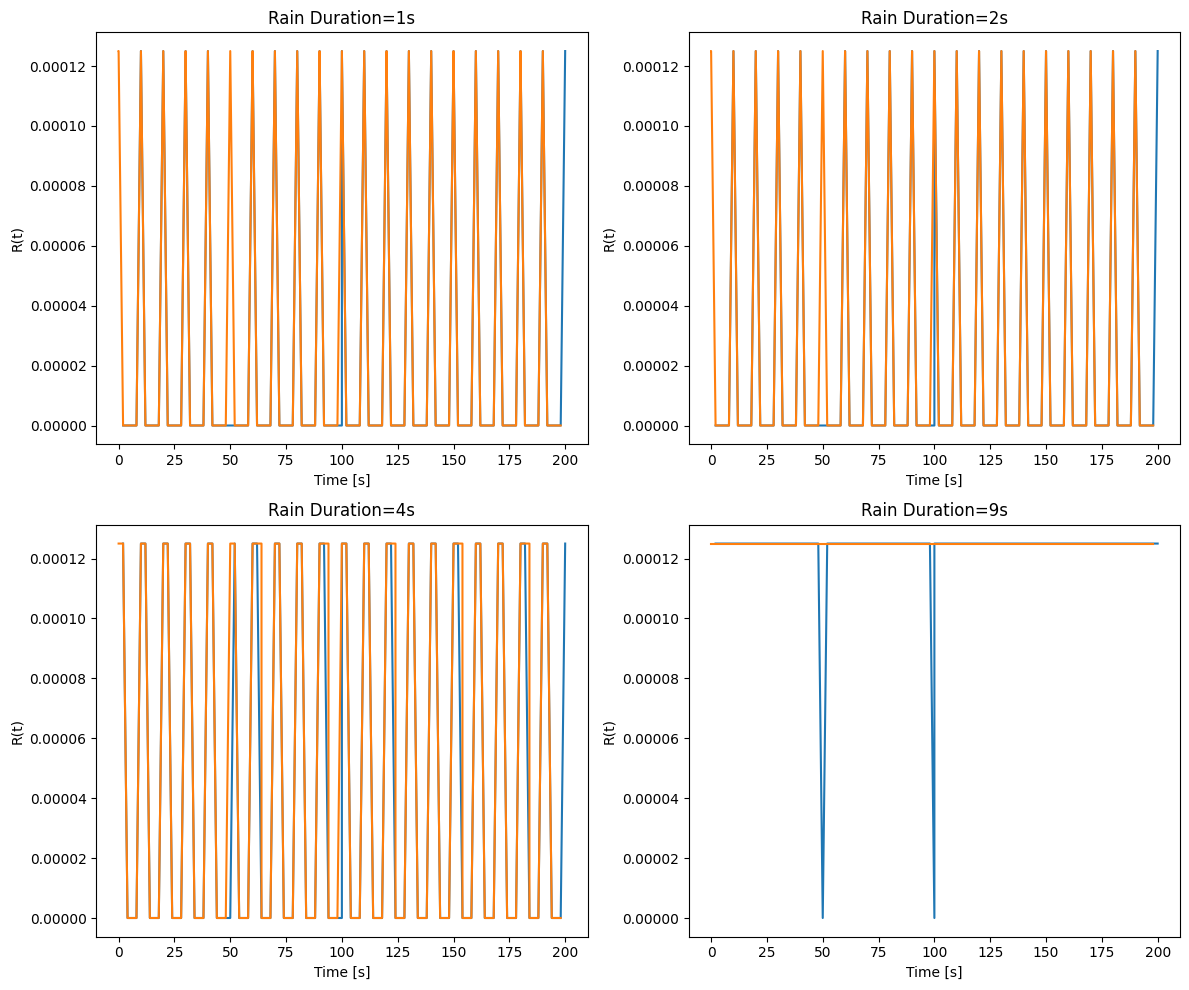

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(t2svar9, rain2svar,label="FE")
axs[0,0].plot(time_fd1s, rain_fd1s,label="FD")
axs[0, 0].set_title('Rain Duration=1s')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].set_ylabel('R(t)')

axs[0, 1].plot(t2svar9, rain2svar2,label="FE")
axs[0,1].plot(time_fd2s, rain_fd2s,label="FD")
axs[0, 1].set_title('Rain Duration=2s')
axs[0,1].set_xlabel('Time [s]')
axs[0,1].set_ylabel('R(t)')

axs[1, 0].plot(t2svar9, rain2svar4,label="FE")
axs[1, 0].plot(time_fd4s, rain_fd4s,label="FD")
axs[1, 0].set_title('Rain Duration=4s')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylabel('R(t)')

axs[1, 1].plot(t2svar9, rain2svar9,label="FE")
axs[1, 1].plot(time_fd9s, rain_fd9s,label="FD")
axs[1, 1].set_title('Rain Duration=9s')
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylabel('R(t)')

plt.tight_layout()
#plt.savefig("water_head_R.png",dpi=1000,format="png",bbox_inches="tight")
#plt.savefig("var_R_comp.png",dpi=500,format="png",bbox_inches="tight")

plt.show()

**Variable Rainfall with stochastic element**

In [ ]:
from firedrake import *
#
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt # OB2025

def flux ( h , phi , R,alpha,g,mpor,sigma ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

def Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=0):
  m  = nx
  Ly = 0.85
  dy = Ly/m
  mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
  y, = SpatialCoordinate(mesh) # OB2025

# Time definitions
  t   = 0.0
  end = t_end
  Ntm = 75
  dtmeas = end/Ntm
  tmeas = dtmeas

#
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
  nCG = 1 # OB2025
  V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
  CFL = 2.3
  Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

  dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
  theta = thet

# Define Groundwater constants
  mpor  = 0.3
  sigma = 0.8
  Lc    = 0.05
  kperm = 1e-8
  w     = 0.1
  R     = Constant(0.000125)
  nu    = 1.0e-6
  g     = 9.81
  alpha = kperm/( nu * mpor * sigma )
  gam   = Lc/( mpor*sigma )
  fac2  = sqrt(g)/( mpor*sigma )
#
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
  nncase = cas

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
  h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
  outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
  outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

  phi = TestFunction(V)

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

  if nncase == 0:
    h = Function(V)
    h.assign(h_prev)
    F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ,alpha,g,mpor,sigma) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
    bc1 = DirichletBC(V, 0.07, 1)
    h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)
  elif nncase == 1:
    if theta == 0.0:
      h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
      explicit_problem = LinearVariationalProblem(aa, L, out)
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij',
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
    elif theta > 0.0:
      h = Function(V)
      h.assign(h_prev)
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
     # Add boundary contributions at y = 0:
      F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
      h_problem = NonlinearVariationalProblem( F+F2 , h )
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})

  time_2s, hcm_2s, rain_2s = [], [], []
  hm_profs_10s, prof_times = [], []
  rain_duration=rain
  Rmax=0.000125
  possible_durations = [1.0, 2.0, 4.0, 9.0]
  probabilities = [3/16, 7/16, 5/16, 1/16]

  # Initialize the first duration
  current_rain_duration = np.random.choice(possible_durations, p=probabilities)
  while (t < end):
    t += Dt
    # Print to console the current time
    if (t % 10.0) < Dt:
        current_rain_duration = np.random.choice(possible_durations, p=probabilities)
        print(f"New Wetropolis Day at t={t:.1f}s: Rain duration set to {current_rain_duration}s")

    if (t % 10.0) < current_rain_duration:
        R_current = Rmax
    else:
        R_current = 0.0
    R.assign(R_current)
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
           h_solver.solve()
           h_prev.assign(h)
        # Write output to file for paraview visualisation
    if round(t, 4) % 2.0 < Dt:
        time_2s.append(t)
        hcm_2s.append(h_prev.at(0.0))
        rain_2s.append(float(R))
    if round(t, 4) % 10.0 < Dt:
        #print(f'Capturing profile at Time: {t:.2f}')
        y_pts = np.linspace(0, Ly, 100)
        hm_profs_10s.append([h_prev.at(yi) for yi in y_pts])
        prof_times.append(t)

    if t>tmeas:
        print('Time is: ',t)
        tmeas = tmeas+dtmeas
        outfile.write(h_prev , t = t )
  return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times

In [ ]:
t2svar, hcm2stoch, rain2stoch, hm_profstoch, prof_timestoch = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=1)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  5.334217500000084
Time is:  8.001326250000467
New Wetropolis Day at t=10.0s: Rain duration set to 1.0s
Time is:  10.668434999999711


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
New Wetropolis Day at t=20.0s: Rain duration set to 4.0s
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
New Wetropolis Day at t=30.0s: Rain duration set to 2.0s


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
New Wetropolis Day at t=40.0s: Rain duration set to 4.0s
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
New Wetropolis Day at t=50.0s: Rain duration set to 4.0s
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
New Wetropolis Day at t=60.0s: Rain duration set to 2.0s
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
New Wetropolis Day at t=70.0s: Rain duration set to 2.0s
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
New Wetropolis Day at t=80.0s: Rain duration set to 1.0s
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
New Wetropolis Day at t=90.0s: Rain duration set to 2.0s
Time is:  90.66715718756825
Time is:  93.

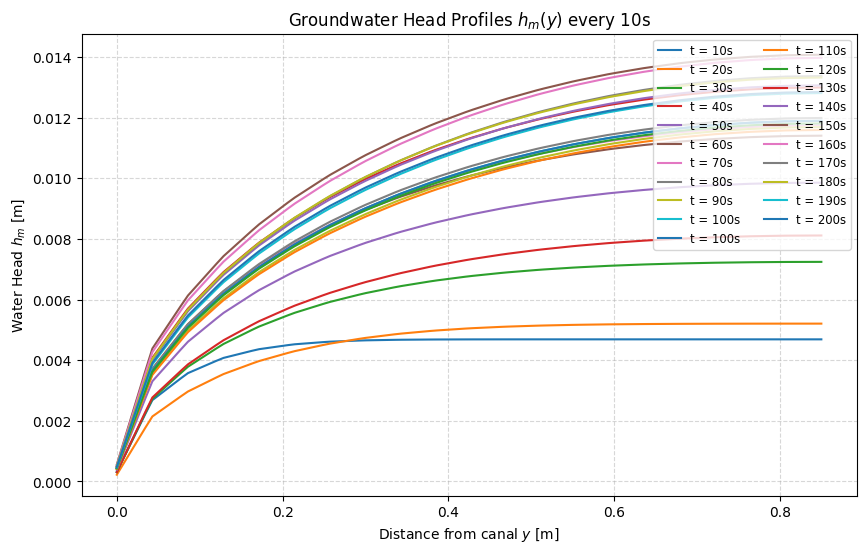

In [ ]:
plt.figure(figsize=(10, 6))
Ly=0.85
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profstoch):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_timestoch[i]:.0f}s')

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

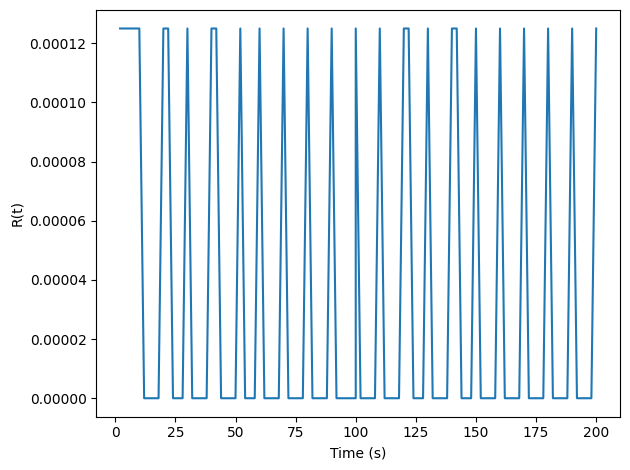

In [ ]:
plt.plot(t2svar, rain2stoch)
plt.xlabel("Time (s)")
plt.ylabel("R(t)")
plt.tight_layout()
plt.savefig("R(t)_prob.png",format="png",dpi=1000,bbox_inches="tight")

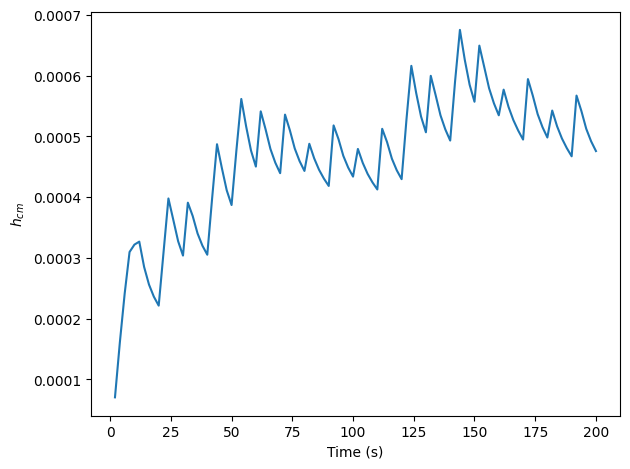

In [ ]:
plt.plot(t2svar, hcm2stoch)
plt.xlabel("Time (s)")
plt.ylabel('$h_{cm}$')
plt.tight_layout()
plt.savefig("hcm_prob.png",format="png",dpi=1000,bbox_inches="tight")

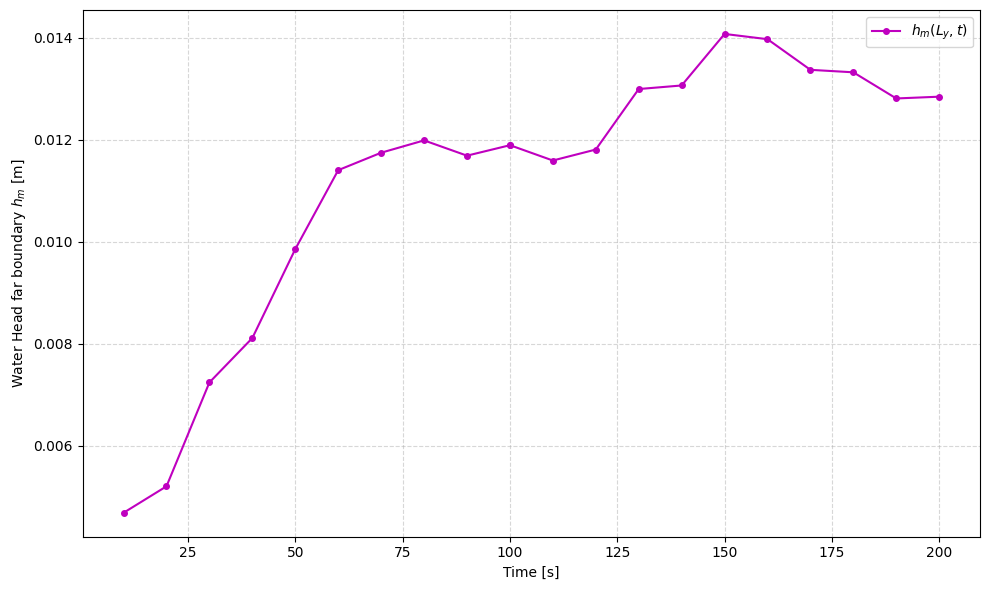

In [ ]:
# Extract the last value from each profile (at y = Ly)
h_at_Ly = [profile[-1] for profile in hm_profstoch]

plt.figure(figsize=(10, 6))
plt.plot(prof_timestoch, h_at_Ly, 'm-o', markersize=4, label='$h_m(L_y, t)$')

#plt.title("Water Head at the Far Boundary ($y = L_y$) over Time")
plt.xlabel("Time [s]")
plt.ylabel("Water Head far boundary $h_m$ [m]")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("water_head_far_boundary_prob.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

**Crank-Nicolson with residuals**

In [2]:
from firedrake import *
from firedrake.petsc import PETSc
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt # OB2025
PETSc.Sys.popErrorHandler()  # ensures PETSc messages are shown

iteration_residuals = []
res_times=[]

def my_monitor(snes, its, norm):
    # This appends the residual norm of the current iteration to our list
    iteration_residuals.append(norm)
    # This ensures we see it in the Colab output
    print(f"  Newton iteration {its}: Residual = {norm:.2e}")


def flux ( h , phi , R,alpha,g,mpor,sigma ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

def Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=0):
  m  = nx
  Ly = 0.85
  dy = Ly/m
  mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
  y, = SpatialCoordinate(mesh) # OB2025

# Time definitions
  t   = 0.0
  end = t_end
  Ntm = 75
  dtmeas = end/Ntm
  tmeas = dtmeas

#
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
  nCG = 2 # OB2025
  V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
  CFL = 2.3
  Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

  dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
  theta = thet

# Define Groundwater constants
  mpor  = 0.3
  sigma = 0.8
  Lc    = 0.05
  kperm = 1e-8
  w     = 0.1
  R     = Constant(0.000125)
  nu    = 1.0e-6
  g     = 9.81
  alpha = kperm/( nu * mpor * sigma )
  gam   = Lc/( mpor*sigma )
  fac2  = sqrt(g)/( mpor*sigma )
#
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
  nncase = cas

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
  h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
  outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
  outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

  phi = TestFunction(V)

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

  if nncase == 0:
    h = Function(V)
    h.assign(h_prev)
    F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ,alpha,g,mpor,sigma) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
    bc1 = DirichletBC(V, 0.07, 1)
    h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)
  elif nncase == 1:
    if theta == 0.0:
      h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
      explicit_problem = LinearVariationalProblem(aa, L, out)
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij',
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
    elif theta > 0.0:
      h = Function(V)
      h.assign(h_prev)
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R,alpha,g,mpor,sigma ) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
     # Add boundary contributions at y = 0:
      F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
      h_problem = NonlinearVariationalProblem( F+F2 , h )
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu',
                                                                          'snes_type': 'newtonls',

                                                                           'snes_max_it': 50,
                                                                           'snes_atol': 1e-15,
                                                                           'snes_rtol': 1e-15,
                                                                           'snes_stol': 1e-15,
                                                                          'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})

  time_2s, hcm_2s, rain_2s = [], [], []
  hm_profs_10s, prof_times = [], []
  rain_duration=rain
  Rmax=0.000125
  first_step_captured = False
  while (t < end):
    t += Dt
    # Print to console the current time
    if (t % 10.0) < rain_duration:
        R_current = Rmax
    else:
        R_current = 0.0
    R.assign(R_current)
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
      if not first_step_captured and t>195:
        print(f"Capturing residuals for t={t:.4f}")
        res_times.append(t)
        h_solver.snes.setMonitor(my_monitor)
        h_solver.solve()
        #first_step_captured = True
        h_solver.snes.cancelMonitor()
        h_prev.assign(h)
        #first_step_captured = True
      else:
        h_solver.solve()
        h_prev.assign(h)

    if round(t, 4) % 2.0 < Dt:
        time_2s.append(t)
        hcm_2s.append(h_prev.at(0.0))
        rain_2s.append(float(R))
    if round(t, 4) % 10.0 < Dt:
        #print(f'Capturing profile at Time: {t:.2f}')
        y_pts = np.linspace(0, Ly, 100)
        hm_profs_10s.append([h_prev.at(yi) for yi in y_pts])
        prof_times.append(t)

    if t>tmeas:
        print('Time is: ',t)
        tmeas = tmeas+dtmeas
        outfile.write(h_prev , t = t )
  return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times


In [ ]:
t2svarcn, hcm2svarcn, rain2svarcn, hm_profsvarcn, prof_timesvarcn = Darcy_model(t_end=200,nx=20,thet=0.5,cas=1,CFL=2.3,rain=10)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Capturing residuals for t=196.5435
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 8.50e-17
Capturing residuals for t=196.5456
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 7.43e-17
Capturing residuals for t=196.5476
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 8.76e-17
Capturing residuals for t=196.5497
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 8.85e-17
Capturing residuals for t=196.5518
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 7.71e-17
Capturing residuals for t=196.5539
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 8.95e-17
Capturing residuals for t=196.5559
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 8.52e-17
Capturing residuals for t=196.5580
  Newton iteration 0: Residual = 1.38e-07
  Newton iteration 1: Residual = 1.08e-

In [ ]:
iteration_residuals

[1.936047138297528e-07,
 9.147742687708006e-17,
 1.9358920792574995e-07,
 8.11060356695308e-17,
 1.9357370326233986e-07,
 1.0727483259557208e-16,
 1.9355819983923532e-07,
 1.1139118632790953e-16,
 1.9354269765654775e-07,
 1.0477216093341002e-16,
 1.935271967139841e-07,
 1.3818421059602178e-16,
 1.935116970116123e-07,
 9.634679611349605e-17,
 1.9349619854929174e-07,
 5.011565744026007e-17,
 1.934807013269797e-07,
 8.820764961899977e-17,
 1.9346520534439623e-07,
 1.1721488250303292e-16,
 1.934497106015878e-07,
 1.1402097900803936e-16,
 1.934342170983252e-07,
 9.573555704819757e-17,
 1.9341872483468453e-07,
 8.872718699594266e-17,
 1.9340323381048758e-07,
 8.967200380373371e-17,
 1.9338774402567596e-07,
 1.1693674168124672e-16,
 1.9337225548001785e-07,
 1.2085824632516641e-16,
 1.9335676817352773e-07,
 8.533171610505662e-17,
 1.9334128210600954e-07,
 7.325208304275716e-17,
 1.9332579727756677e-07,
 1.1431294901389077e-16,
 1.9331031368789462e-07,
 1.1757339999814153e-16,
 1.93294831336982

In [ ]:
res_times

[195.00013093743718,
 195.00220812493717,
 195.00428531243716,
 195.00636249993715,
 195.00843968743715,
 195.01051687493714,
 195.01259406243713,
 195.01467124993712,
 195.01674843743712,
 195.0188256249371,
 195.0209028124371,
 195.0229799999371,
 195.02505718743708,
 195.02713437493708,
 195.02921156243707,
 195.03128874993706,
 195.03336593743705,
 195.03544312493705,
 195.03752031243704,
 195.03959749993703,
 195.04167468743702,
 195.04375187493702,
 195.045829062437,
 195.047906249937,
 195.049983437437,
 195.05206062493698,
 195.05413781243698,
 195.05621499993697,
 195.05829218743696,
 195.06036937493695,
 195.06244656243695,
 195.06452374993694,
 195.06660093743693,
 195.06867812493692,
 195.07075531243692,
 195.0728324999369,
 195.0749096874369,
 195.0769868749369,
 195.07906406243688,
 195.08114124993688,
 195.08321843743687,
 195.08529562493686,
 195.08737281243685,
 195.08944999993685,
 195.09152718743684,
 195.09360437493683,
 195.09568156243682,
 195.09775874993682,
 195

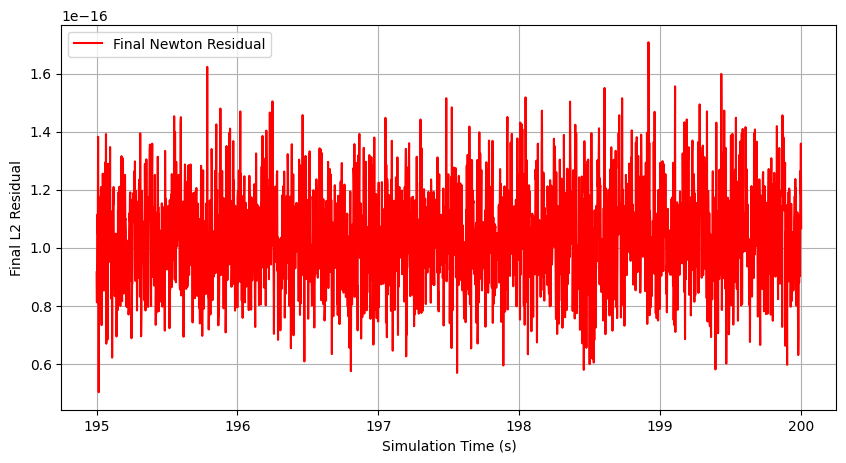

In [ ]:
# Extract only the 2nd iteration (the final one) for each time step
final_residuals = iteration_residuals[1::2] # Starts at index 1, takes every 2nd element

plt.figure(figsize=(10, 5))
plt.plot(res_times, final_residuals, 'r-', label='Final Newton Residual')

plt.xlabel("Simulation Time (s)")
plt.ylabel("Final L2 Residual")
#plt.title("Solver Stability over 100s Simulation")
plt.grid(True)
plt.legend()
#plt.savefig("solver_stability.png",dpi=1000,format="png",bbox_inches="tight")
plt.show()

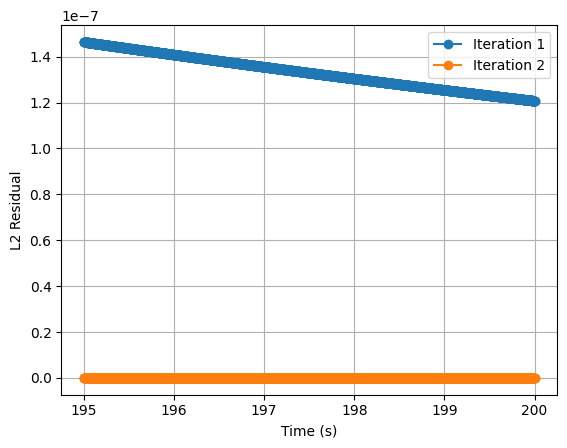

In [ ]:
res_times = np.array(res_times)
iteration_residuals = np.array(iteration_residuals)

# last 5 time steps
last_times = res_times
last_residuals = iteration_residuals

res_iter1 = last_residuals[0::2]
res_iter2 = last_residuals[1::2]
plt.plot(last_times, res_iter1, 'o-', label='Iteration 1')
plt.plot(last_times, res_iter2, 'o-', label='Iteration 2')
plt.ticklabel_format(useOffset=False, style='plain', axis='x')
plt.xlabel("Time (s)")
plt.ylabel("L2 Residual")
plt.legend()
plt.grid(True)
plt.savefig("solver_stability_last50.png",dpi=1000,format="png",bbox_inches="tight")

plt.show()

array([199.99368969, 199.99576687, 199.99784406, 199.99992125,
       200.00199844])

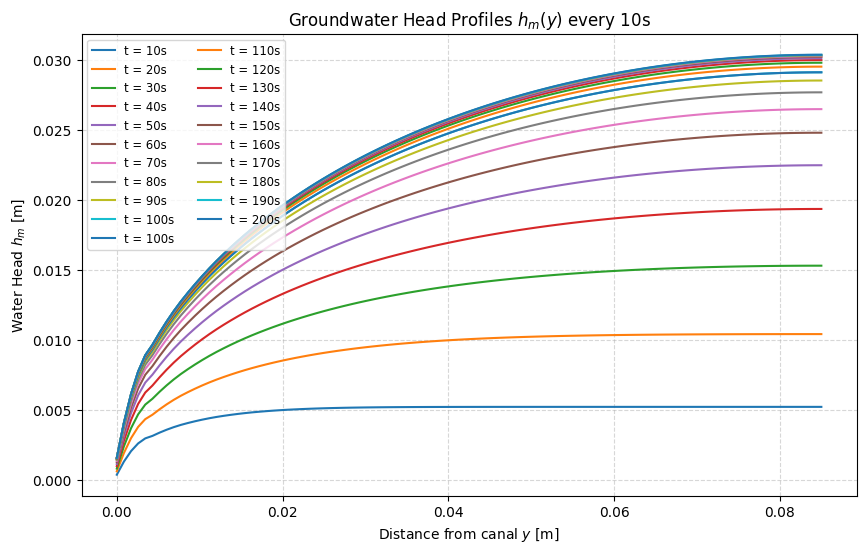

In [ ]:
plt.figure(figsize=(10, 6))
Ly=0.085
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profsvarcn):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_timesvarcn[i]:.0f}s')

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.savefig("CN_profile.png",dpi=1000,format="png",bbox_inches="tight")

plt.show()

In [3]:
t2svarcn1, hcm2svarcn1, rain2svarcn1, hm_profsvarcn1, prof_timesvarcn1 = Darcy_model(t_end=200,nx=20,thet=0.5,cas=1,CFL=2.3,rain=1)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  Newton iteration 0: Residual = 5.15e-06
  Newton iteration 1: Residual = 2.67e-15
  Newton iteration 2: Residual = 2.02e-17
Capturing residuals for t=197.4097
  Newton iteration 0: Residual = 5.15e-06
  Newton iteration 1: Residual = 2.67e-15
  Newton iteration 2: Residual = 2.28e-17
Capturing residuals for t=197.4117
  Newton iteration 0: Residual = 5.15e-06
  Newton iteration 1: Residual = 2.67e-15
  Newton iteration 2: Residual = 2.23e-17
Capturing residuals for t=197.4138
  Newton iteration 0: Residual = 5.15e-06
  Newton iteration 1: Residual = 2.67e-15
  Newton iteration 2: Residual = 2.35e-17
Capturing residuals for t=197.4159
  Newton iteration 0: Residual = 5.15e-06
  Newton iteration 1: Residual = 2.67e-15
  Newton iteration 2: Residual = 3.02e-17
Capturing residuals for t=197.4180
  Newton iteration 0: Residual = 5.15e-06
  Newton iteration 1: Residual = 2.67e-15
  Newton iteration 2: Residual = 2.72e-17
Capturing residual

In [4]:
t2svarcn2, hcm2svarcn2, rain2svarcn2, hm_profsvarcn2, prof_timesvarcn2 = Darcy_model(t_end=200,nx=20,thet=0.5,cas=1,CFL=2.3,rain=2)

Streaming output truncated to the last 5000 lines.
  Newton iteration 0: Residual = 1.24e-05
  Newton iteration 1: Residual = 9.54e-15
  Newton iteration 2: Residual = 2.83e-17
Capturing residuals for t=197.4097
  Newton iteration 0: Residual = 1.24e-05
  Newton iteration 1: Residual = 9.54e-15
  Newton iteration 2: Residual = 3.18e-17
Capturing residuals for t=197.4117
  Newton iteration 0: Residual = 1.24e-05
  Newton iteration 1: Residual = 9.54e-15
  Newton iteration 2: Residual = 3.70e-17
Capturing residuals for t=197.4138
  Newton iteration 0: Residual = 1.24e-05
  Newton iteration 1: Residual = 9.54e-15
  Newton iteration 2: Residual = 3.74e-17
Capturing residuals for t=197.4159
  Newton iteration 0: Residual = 1.24e-05
  Newton iteration 1: Residual = 9.54e-15
  Newton iteration 2: Residual = 3.70e-17
Capturing residuals for t=197.4180
  Newton iteration 0: Residual = 1.24e-05
  Newton iteration 1: Residual = 9.52e-15
  Newton iteration 2: Residual = 2.87e-17
Capturing residual

In [5]:
t2svarcn3, hcm2svarcn3, rain2svarcn3, hm_profsvarcn3, prof_timesvarcn3 = Darcy_model(t_end=200,nx=20,thet=0.5,cas=1,CFL=2.3,rain=4)

Streaming output truncated to the last 5000 lines.
  Newton iteration 0: Residual = 2.76e-05
  Newton iteration 1: Residual = 4.14e-14
  Newton iteration 2: Residual = 4.87e-17
Capturing residuals for t=197.4097
  Newton iteration 0: Residual = 2.76e-05
  Newton iteration 1: Residual = 4.14e-14
  Newton iteration 2: Residual = 6.53e-17
Capturing residuals for t=197.4117
  Newton iteration 0: Residual = 2.76e-05
  Newton iteration 1: Residual = 4.14e-14
  Newton iteration 2: Residual = 5.32e-17
Capturing residuals for t=197.4138
  Newton iteration 0: Residual = 2.76e-05
  Newton iteration 1: Residual = 4.14e-14
  Newton iteration 2: Residual = 6.41e-17
Capturing residuals for t=197.4159
  Newton iteration 0: Residual = 2.76e-05
  Newton iteration 1: Residual = 4.13e-14
  Newton iteration 2: Residual = 5.98e-17
Capturing residuals for t=197.4180
  Newton iteration 0: Residual = 2.76e-05
  Newton iteration 1: Residual = 4.13e-14
  Newton iteration 2: Residual = 6.57e-17
Capturing residual

In [6]:
t2svarcn4, hcm2svarcn4, rain2svarcn4, hm_profsvarcn4, prof_timesvarcn4 = Darcy_model(t_end=200,nx=20,thet=0.5,cas=1,CFL=2.3,rain=9)

Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711
Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  Newton iteration 1: Residual = 1.16e-15
  Newton iteration 2: Residual = 8.17e-17
Capturing residuals for t=197.2123
  Newton iteration 0: Residual = 6.41e-06
  Newton iteration 1: Residual = 1.17e-15
  Newton iteration 2: Residual = 7.55e-17
Capturing residuals for t=197.2144
  Newton iteration 0: Residual = 6.41e-06
  Newton iteration 1: Residual = 1.17e-15
  Newton iteration 2: Residual = 8.91e-17
Capturing residuals for t=197.2165
  Newton iteration 0: Residual = 6.41e-06
  Newton iteration 1: Residual = 1.15e-15
  Newton iteration 2: Residual = 6.81e-17
Capturing residuals for t=197.2186
  Newton iteration 0: Residual = 6.41e-06
  Newton iteration 1: Residual = 1.16e-15
  Newton iteration 2: Residual = 7.65e-17
Capturing residuals for t=197.2206
  Newton iteration 0: Residual = 6.40e-06
  Newton iteration 1: Residual = 1.17e-15
  Newton iteration 2: Residual = 8.16e-17
Capturing residuals for t=197.2227
  Newton iteration 0: Res

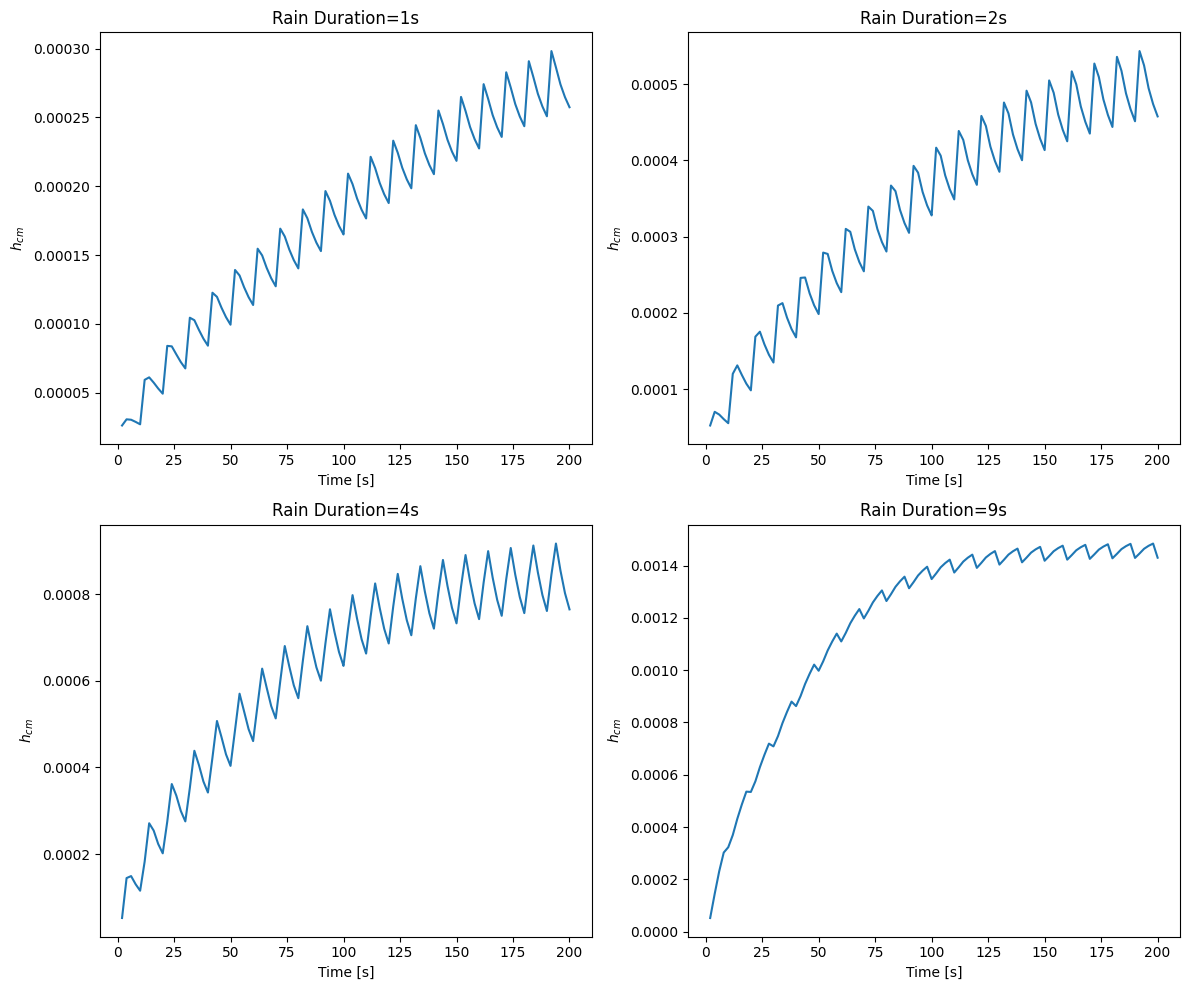

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(t2svarcn1, hcm2svarcn1)
axs[0, 0].set_title('Rain Duration=1s')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].set_ylabel('$h_{cm}$')

axs[0, 1].plot(t2svarcn1, hcm2svarcn2)
axs[0, 1].set_title('Rain Duration=2s')
axs[0,1].set_xlabel('Time [s]')
axs[0,1].set_ylabel('$h_{cm}$')

axs[1, 0].plot(t2svarcn1, hcm2svarcn3)
axs[1, 0].set_title('Rain Duration=4s')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylabel('$h_{cm}$')

axs[1, 1].plot(t2svarcn1, hcm2svarcn4)
axs[1, 1].set_title('Rain Duration=9s')
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylabel('$h_{cm}$')

plt.tight_layout()
#plt.savefig("water_head_hcm_var.png",dpi=1000,format="png",bbox_inches="tight")

plt.show()

**Test explicit euler with different CFL**

In [13]:
from firedrake import *
from firedrake.petsc import PETSc
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd # OB2025
import numpy as np # OB2025
import matplotlib.pyplot as plt # OB2025
PETSc.Sys.popErrorHandler()  # ensures PETSc messages are shown

iteration_residuals = []
res_times=[]

def my_monitor(snes, its, norm):
    # This appends the residual norm of the current iteration to our list
    iteration_residuals.append(norm)
    # This ensures we see it in the Colab output
    print(f"  Newton iteration {its}: Residual = {norm:.2e}")


def flux ( h , phi , R,alpha,g,mpor,sigma ):  # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )

def Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=0,CG=1):
  m  = nx
  Ly = 0.85
  dy = Ly/m
  mesh = IntervalMesh(m, 0 , Ly)
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
  y, = SpatialCoordinate(mesh) # OB2025

# Time definitions
  t   = 0.0
  end = t_end
  Ntm = 75
  dtmeas = end/Ntm
  tmeas = dtmeas

#
# Define Function space on our mesh.
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
  nCG = 3 # OB2025
  V = FunctionSpace(mesh, "CG", nCG) # OB2025

# Define timestep value
 # CFL = CFL
  Dt = CFL*0.5*dy*dy  # Based on FD estimate; note that dt must be defined before flux, etc
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

  dt = Constant(Dt) # Using dt.assign in the while loop should avoid having to rebuild the solver iirc

# Define Crank Nicholson parameter
  theta = thet

# Define Groundwater constants
  mpor  = 0.3
  sigma = 0.8
  Lc    = 0.05
  kperm = 1e-8
  w     = 0.1
  R     = Constant(0.000125)
  nu    = 1.0e-6
  g     = 9.81
  alpha = kperm/( nu * mpor * sigma )
  gam   = Lc/( mpor*sigma )
  fac2  = sqrt(g)/( mpor*sigma )
#
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
  nncase = cas

# Initial condition
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
  h_prev = Function(V).interpolate(0.0 + 0.0*y) # OB2025 IC, I guess hnum = 0.0*y h_prev.interpolate(hnum)

# Create storage for paraview
  outfile = VTKFile("./Results/groundwater_onnob.pvd")

# Write IC to file for paraview
  outfile.write(h_prev , t = t )

# Define trial and test functions on this function space
# h will be the equivalent to h^n+1 in our timestepping scheme

  phi = TestFunction(V)

## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

  if nncase == 0:
    h = Function(V)
    h.assign(h_prev)
    F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ,alpha,g,mpor,sigma) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
   # Boundary conditions: Condition at Ly satisfied weakly
    bc1 = DirichletBC(V, 0.07, 1)
    h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)
  elif nncase == 1:
    if theta == 0.0:
      h, out = TrialFunction(V), Function(V) # Has to be set for linear solver
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29)
      explicit_problem = LinearVariationalProblem(aa, L, out)
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij',
        'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})
    elif theta > 0.0:
      h = Function(V)
      h.assign(h_prev)
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R,alpha,g,mpor,sigma ) + (1-theta)* flux ( h_prev, phi, R,alpha,g,mpor,sigma) ) *dx
     # Add boundary contributions at y = 0:
      F2 = ( gam*phi*(h-h_prev)/dt+theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)+(1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)
      h_problem = NonlinearVariationalProblem( F+F2 , h )
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu',
                                                                          'snes_type': 'newtonls',

                                                                           'snes_max_it': 50,
                                                                           'snes_atol': 1e-15,
                                                                           'snes_rtol': 1e-15,
                                                                           'snes_stol': 1e-15,
                                                                          'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})

  time_2s, hcm_2s, rain_2s = [], [], []
  hm_profs_10s, prof_times = [], []
  rain_duration=rain
  Rmax=0.000125
  first_step_captured = False
  while (t < end):
    t += Dt
    # Print to console the current time
    if (t % 10.0) < rain_duration:
        R_current = Rmax
    else:
        R_current = 0.0
    R.assign(R_current)
    if theta == 0.0:
           explicit_solver.solve()
           h_prev.assign(out) # has to be renamed via out
    elif theta > 0.0:
      if not first_step_captured and t>195:
        print(f"Capturing residuals for t={t:.4f}")
        res_times.append(t)
        h_solver.snes.setMonitor(my_monitor)
        h_solver.solve()
        #first_step_captured = True
        h_solver.snes.cancelMonitor()
        h_prev.assign(h)
        #first_step_captured = True
      else:
        h_solver.solve()
        h_prev.assign(h)

    if round(t, 4) % 2.0 < Dt:
        time_2s.append(t)
        hcm_2s.append(h_prev.at(0.0))
        rain_2s.append(float(R))
    if round(t, 4) % 10.0 < Dt:
        #print(f'Capturing profile at Time: {t:.2f}')
        y_pts = np.linspace(0, Ly, 100)
        hm_profs_10s.append([h_prev.at(yi) for yi in y_pts])
        prof_times.append(t)

    if t>tmeas:
        print('Time is: ',t)
        tmeas = tmeas+dtmeas
        outfile.write(h_prev , t = t )
  return time_2s, hcm_2s, rain_2s, hm_profs_10s, prof_times

In [14]:
t2svarosc, hcm2svarosc, rain2svarosc, hm_profsvarosc, prof_timesvarosc = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=2.3,rain=10,CG=2)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.6671087499999846


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  5.334217500000084
Time is:  8.001326250000467
Time is:  10.668434999999711


/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  13.333466562498955
Time is:  16.0005753124982
Time is:  18.667684062497443
Time is:  21.334792812496687
Time is:  24.00190156249593
Time is:  26.666933124995175
Time is:  29.33404187499442
Time is:  32.00115062499366
Time is:  34.66825937499291
Time is:  37.33536812499215
Time is:  40.000399687491395
Time is:  42.66750843749064
Time is:  45.33461718748988
Time is:  48.00172593748913
Time is:  50.66675749998837
Time is:  53.333866249987615
Time is:  56.00097499998686
Time is:  58.6680837499861
Time is:  61.33519249998535
Time is:  64.00022406248459
Time is:  66.66733281249296
Time is:  69.33444156250133
Time is:  72.00155031250969
Time is:  74.66865906251806
Time is:  77.33369062502642
Time is:  80.00079937503479
Time is:  82.66790812504316
Time is:  85.33501687505152
Time is:  88.00004843755988
Time is:  90.66715718756825
Time is:  93.33426593757662
Time is:  96.00137468758498
Time is:  98.66848343759335
Time is:  101.33351500010171
Time is:  104.00062375011008
Time is:  106.

In [15]:
t2svarosc2, hcm2svarosc2, rain2svarosc2, hm_profsvarosc2, prof_timesvarosc2 = Darcy_model(t_end=200,nx=20,thet=0,cas=1,CFL=1,rain=10,CG=2)

/usr/local/lib/python3.12/dist-packages/firedrake/function.py:560: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  2.666928124999849
Time is:  5.333856249999207
Time is:  8.000784374998565
Time is:  10.666809375000545
Time is:  13.333737500002526
Time is:  16.000665625004505
Time is:  18.666690625006485
Time is:  21.333618750008466
Time is:  24.000546875010446
Time is:  26.667475000012427
Time is:  29.333500000014407
Time is:  32.000428125016384
Time is:  34.667356250018365
Time is:  37.333381250020345
Time is:  40.000309375022326
Time is:  42.66723750002431
Time is:  45.33416562502629
Time is:  48.00019062502827
Time is:  50.66711875003025
Time is:  53.33404687503223
Time is:  56.00007187503421
Time is:  58.66700000003619
Time is:  61.33392812503817
Time is:  64.00085625004014
Time is:  66.66688125002115
Time is:  69.33380937500215
Time is:  72.00073749998315
Time is:  74.66676249996415
Time is:  77.33369062494515
Time is:  80.00061874992615
Time is:  82.66754687490715
Time is:  85.33357187488815
Time is:  88.00049999986915
Time is:  90.66742812485015
Time is:  93.33345312483115
Time is:

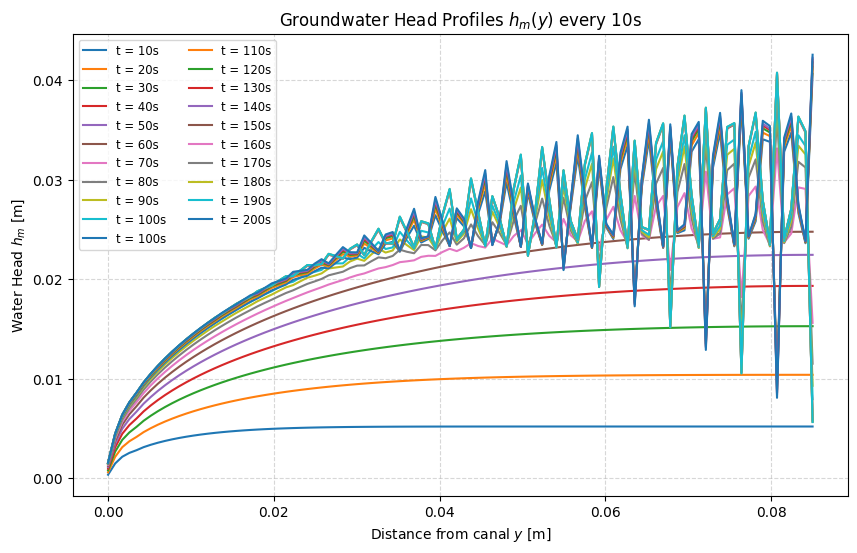

In [16]:
plt.figure(figsize=(10, 6))
Ly=0.085
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profsvarosc):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_timesvarosc[i]:.0f}s')

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()

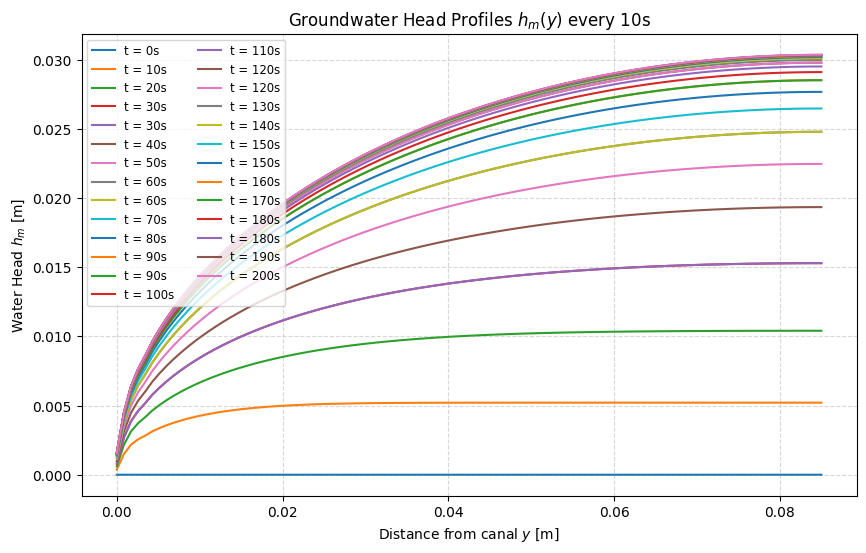

In [17]:
plt.figure(figsize=(10, 6))
Ly=0.085
# Define the spatial points for the x-axis (y-direction)
y_plot = np.linspace(0, Ly, 100)

# Loop through the saved profiles and plot each one
for i, profile in enumerate(hm_profsvarosc2):
    # prof_times[i] gives us the timestamp for the legend
    plt.plot(y_plot, profile, label=f't = {prof_timesvarosc2[i]:.0f}s')

plt.title("Groundwater Head Profiles $h_m(y)$ every 10s")
plt.xlabel("Distance from canal $y$ [m]")
plt.ylabel("Water Head $h_m$ [m]")
plt.legend(loc='upper left', ncol=2, fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()

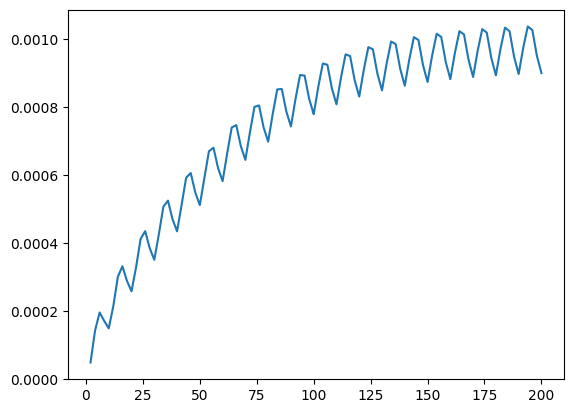

In [ ]:
plt.plot(t2svarosc,hcm2svarosc)